# Convolutional Neural Network Model for Land Classification

## VGG16 Sequential

### Importing Necessary Libraries

In [1]:
# Suppress warnings from libraries to keep the output clean
import warnings
warnings.filterwarnings('ignore')

# Import standard Python libraries
import os  # For operating system dependent functionality
import shutil  # For file operations like copying and removing files
import itertools  # For advanced iteration operations
import random  # For generating random numbers

# Import scientific computing libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import matplotlib.image as mpimg  # For reading image files

# Import TensorFlow, a deep learning library
import tensorflow as tf

# Import Keras, a high-level API for building and training deep learning models
import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import backend as K  # For accessing the Keras backend
from tensorflow.keras.applications import imagenet_utils  # Utilities for ImageNet data
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For real-time data augmentation
from tensorflow.keras.preprocessing import image  # For image preprocessing utilities
from tensorflow.keras.metrics import categorical_crossentropy  # Loss function for multi-class classification
from tensorflow.keras.optimizers import Adam  # Optimizer for training models
from tensorflow.keras.models import Sequential, Model, load_model  # For creating and loading models
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Import various Keras layers for building neural networks
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D
from tensorflow.keras.layers import Activation, Dense, Flatten, Input, Dropout

# Import scikit-learn and SciPy libraries
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy import misc, ndimage  # For image processing

# Import for plotting model architecture
from tensorflow.keras.utils import plot_model  # For creating a visual representation of the model

from tabulate import tabulate

# Enable inline plotting in Jupyter notebooks
%matplotlib inline

### Setting Up A Reproducible Environment

In [2]:
# Restore np.random.seed to its original state
np.random.seed = np.random.seed

# Ensure np.random.seed is not reassigned
assert isinstance(np.random.seed, type(np.random.RandomState().seed)), "np.random.seed has been reassigned."

# Set up a reproducible environment
# Setting a specific hash seed for Python's hash-based operations
os.environ['PYTHONHASHSEED'] = '0'
# Setting the seed for NumPy's random number generator
np.random.seed(123)
# Setting the seed for Python's random module
random.seed(456)
# Setting the seed for TensorFlow's random number generator
tf.random.set_seed(789)

# Configure TensorFlow session to use a single thread for operations
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

### Setting the Paths

In [3]:
# Set the path to the main dataset and the path to the train, valid and test folders within the dataset_splits folder
base_path = 'C:/Users/isaac/datasets/eurosat-dataset'
dataset_path = 'C:/Users/isaac/datasets'
train_path = os.path.join(base_path, 'dataset_splits/train')
valid_path = os.path.join(base_path, 'dataset_splits/valid')
test_path = os.path.join(base_path, 'dataset_splits/test')

### Storing the Categories

In [4]:
# Initialize an empty list to store category names
categories = []

# Walk through the directory tree starting from the specified path
for dirpath, dirnames, filenames in os.walk(base_path):
    # Filter out 'dataset_splits' directory from the list of dirnames
    # This will modify dirnames in-place and prevent os.walk from visiting this directory
    dirnames[:] = [d for d in dirnames if d != 'dataset_splits']
    
    # Add the remaining directory names (categories) to the categories list
    categories.extend(dirnames)

# Print the list of categories (subdirectory names)
print(categories)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


### Counting Images in Train, Validation, and Test Sets

In [5]:
# Iterate through each category within the categories list 
for category in categories:
    # Construct the path to the training images directory for the current category
    tr = os.path.join(train_path, category)
    # Get the number of training images in the current category
    len_tr = len(os.listdir(tr))

    # Construct the path to the validation images directory for the current category
    val = os.path.join(valid_path, category)
    # Get the number of validation images in the current category
    len_val = len(os.listdir(val))

    # Construct the path to the test images directory for the current category
    test = os.path.join(test_path, category)
    # Get the number of test images in the current category
    len_test = len(os.listdir(test))

    # Printing the category names and the training, validation and test images for each category
    print(category + ":")
    print('Train images for ' + category + ': {}'.format(len_tr))
    print('Validation images for ' + category + ': {}'.format(len_val))
    print('Test images for ' + category + ': {}'.format(len_test))
    print('')

AnnualCrop:
Train images for AnnualCrop: 1200
Validation images for AnnualCrop: 150
Test images for AnnualCrop: 150

Forest:
Train images for Forest: 1200
Validation images for Forest: 150
Test images for Forest: 150

HerbaceousVegetation:
Train images for HerbaceousVegetation: 1200
Validation images for HerbaceousVegetation: 150
Test images for HerbaceousVegetation: 150

Highway:
Train images for Highway: 1000
Validation images for Highway: 125
Test images for Highway: 125

Industrial:
Train images for Industrial: 1000
Validation images for Industrial: 125
Test images for Industrial: 125

Pasture:
Train images for Pasture: 800
Validation images for Pasture: 100
Test images for Pasture: 100

PermanentCrop:
Train images for PermanentCrop: 1000
Validation images for PermanentCrop: 125
Test images for PermanentCrop: 125

Residential:
Train images for Residential: 1200
Validation images for Residential: 150
Test images for Residential: 150

River:
Train images for River: 1000
Validation im

### Creating Data Generators for Train, Validation, and Test Sets

In [6]:
# Create a data generator for the training dataset
# This generator will load and preprocess images from the 'train_path' directory
train_batches = ImageDataGenerator().flow_from_directory(
    train_path,
    target_size=(64, 64),
    classes=categories,
    batch_size=32
)
# Create a data generator for the validation dataset
# This generator will load and preprocess images from the 'valid_path' directory
valid_batches = ImageDataGenerator().flow_from_directory(
    valid_path,
    target_size=(64, 64),
    classes=categories,
    batch_size=16
)
# Create a data generator for the test dataset
# This generator will load and preprocess images from the 'test_path' directory
test_batches = ImageDataGenerator().flow_from_directory(
    test_path,
    target_size=(64, 64),
    classes=categories,
    batch_size=16,
    shuffle=False)

Found 10800 images belonging to 10 classes.
Found 1350 images belonging to 10 classes.
Found 1350 images belonging to 10 classes.


### Defining and Demonstrating Image Plotting Function

In [7]:
# Function to plot images with labels
def plots(ims, figsize=(30, 15), rows=1, interp=False, titles=None):
    # Check if the input is a list of numpy arrays
    if isinstance(ims[0], np.ndarray):
        # Convert to uint8 type for image display
        ims = np.array(ims).astype(np.uint8)
        # Ensure the images have the correct shape for display
        if ims.shape[-1] != 3:  # Check if the last dimension is not 3 (RGB channels)
            ims = ims.transpose((0, 2, 3, 1))  # Rearrange dimensions to (N, H, W, C)

    # Create a new figure with the specified size
    f, axes = plt.subplots(rows, len(ims) // rows + (len(ims) % rows != 0), figsize=figsize)
    
    # Flatten axes array if there are multiple rows
    if rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Iterate through images and plot them
    for i, ax in enumerate(axes):
        if i < len(ims):
            ax.axis('Off')  # Turn off axis lines and labels
            if titles is not None and i < len(titles):
                ax.set_title(titles[i], fontsize=16)  # Set title if provided
            ax.imshow(ims[i], interpolation='none' if not interp else 'bilinear')  # Display image
        else:
            ax.axis('Off')  # Hide any extra subplots
    
    plt.tight_layout()  # Adjust subplot params so that the subplot(s) fits in to the figure area
    plt.show()  # Display the figure

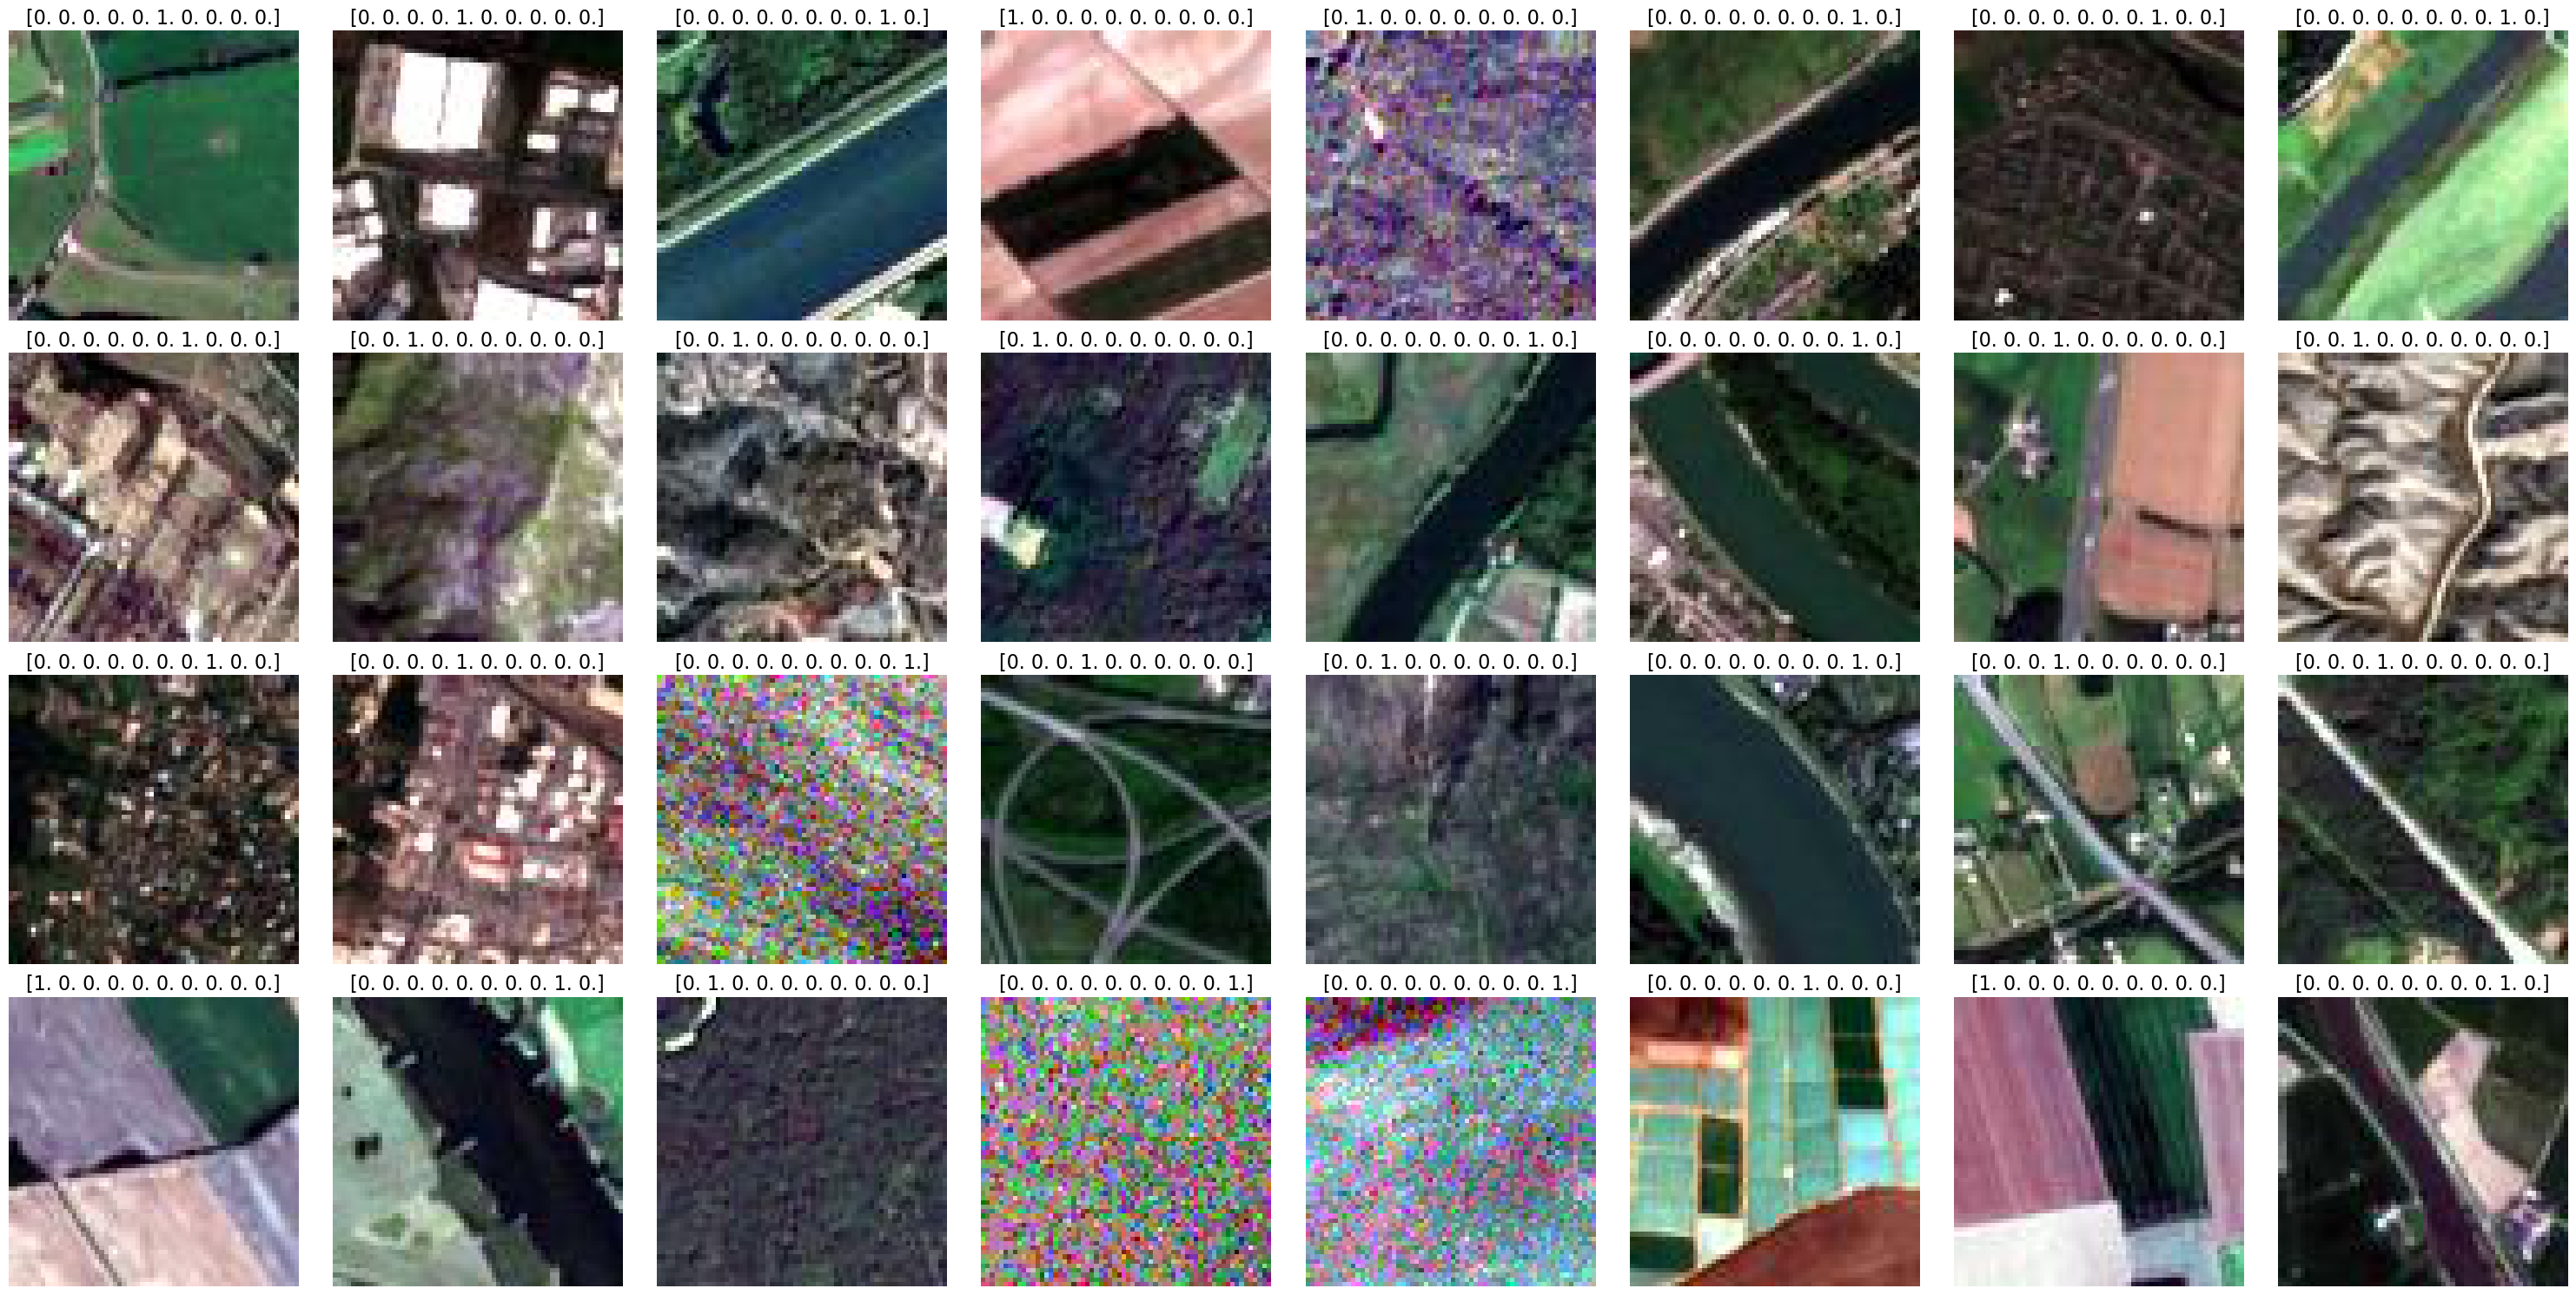

In [8]:
# Example usage with a batch of images and labels
imgs, labels = next(train_batches)  # Get a batch of images and labels from the data generator
plots(imgs, rows=4, titles=labels)  # Plot the images with titles

# Using Transfer Learning to build the CNN

### Summarising the VGG16 Model 

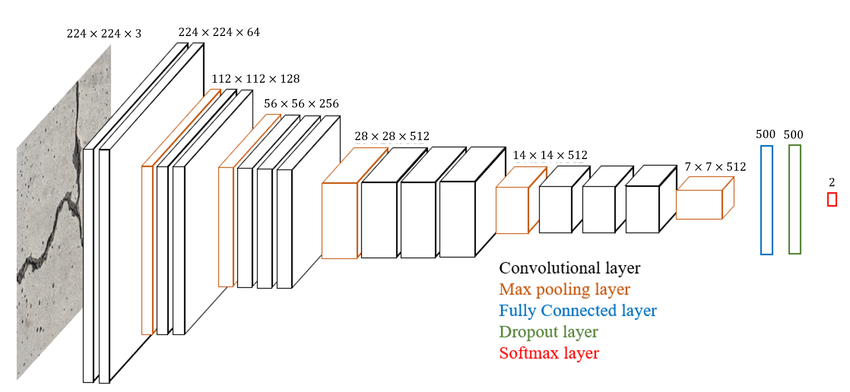

In [9]:
# Import VGG16 model from Keras applications module
vgg16_model = tensorflow.keras.applications.vgg16.VGG16(include_top=False, input_shape=(64,64,3))

# Display summary of the VGG16 model architecture
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### Transferring the VGG16 Architecture to a Sequential Model

In [10]:
# Create a new Sequential model
model = Sequential()

# Iterate through each layer in the pre-trained VGG16 model and add it to the new model
for layer in vgg16_model.layers:
    model.add(layer)

# Display summary of the new Sequential model, which now matches the VGG16 architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### Freezing Layers for Transfer Learning and Adding Classification Layers

In [11]:
# Define the number of layers to freeze to adapt to the new dataset
NUM_TRAINABLE_LAYERS = 10

# Freeze the weights of all layers except the last NUM_TRAINABLE_LAYERS layers
for layer in model.layers[:-NUM_TRAINABLE_LAYERS]:
    layer.trainable = False  # Exclude layer from future training to retain pre-trained weights

# Add additional layers for fine-tuning and classification
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(categories), activation='softmax'))

# Display summary of the updated model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,031,562 (61.16 MB)

 Trainable params: 14,886,154 (56.79 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

### Training the transfer CNN model

In [12]:
# Define the optimizer with the desired learning rate
optimizer = Adam(learning_rate=0.0001)

# Compile the model using the defined optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
%%time
history = model.fit(
    train_batches,  # Data generator for the training data
    steps_per_epoch=1080,  # Number of batches to draw from `train_batches` for each epoch
    validation_data=valid_batches,  # Data generator for the validation data
    validation_steps=270,  # Number of batches to draw from `valid_batches` for validation after each epoch
    epochs=10,  # Number of times the model will go through the entire training dataset
    verbose=2  # Level of logging verbosity (2 provides one line of output per epoch with loss and accuracy)
)

Epoch 1/10
1080/1080 - 797s - 738ms/step - accuracy: 0.7845 - loss: 0.7319 - val_accuracy: 0.9081 - val_loss: 0.2833
Epoch 2/10
1080/1080 - 805s - 745ms/step - accuracy: 0.9177 - loss: 0.2632 - val_accuracy: 0.9081 - val_loss: 0.3546
Epoch 3/10
1080/1080 - 660s - 611ms/step - accuracy: 0.9435 - loss: 0.1835 - val_accuracy: 0.9326 - val_loss: 0.2720
Epoch 4/10
1080/1080 - 543s - 503ms/step - accuracy: 0.9568 - loss: 0.1410 - val_accuracy: 0.9296 - val_loss: 0.2946
Epoch 5/10
1080/1080 - 535s - 495ms/step - accuracy: 0.9640 - loss: 0.1172 - val_accuracy: 0.9178 - val_loss: 0.2673
Epoch 6/10
1080/1080 - 556s - 514ms/step - accuracy: 0.9688 - loss: 0.1039 - val_accuracy: 0.9007 - val_loss: 0.3305
Epoch 7/10
1080/1080 - 573s - 530ms/step - accuracy: 0.9705 - loss: 0.0967 - val_accuracy: 0.9444 - val_loss: 0.2577
Epoch 8/10
1080/1080 - 574s - 531ms/step - accuracy: 0.9756 - loss: 0.0803 - val_accuracy: 0.9230 - val_loss: 0.3029
Epoch 9/10
1080/1080 - 631s - 584ms/step - accuracy: 0.9780 - lo

### Evaluating the Test Labels and Class Indices

In [19]:
# Get the class-to-index mapping from the test_batches ImageDataGenerator
class_indices = {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}

# Convert the dictionary to a list of lists
class_list = [[class_name, index] for class_name, index in class_indices.items()]

# Get the class indices from the test_batches ImageDataGenerator
test_labels = test_batches.classes

# Print the table
print(tabulate(class_list, headers=['Class Name', 'Index'], tablefmt='grid'))

+----------------------+---------+
| Class Name           |   Index |
+======================+=========+
| AnnualCrop           |       0 |
+----------------------+---------+
| Forest               |       1 |
+----------------------+---------+
| HerbaceousVegetation |       2 |
+----------------------+---------+
| Highway              |       3 |
+----------------------+---------+
| Industrial           |       4 |
+----------------------+---------+
| Pasture              |       5 |
+----------------------+---------+
| PermanentCrop        |       6 |
+----------------------+---------+
| Residential          |       7 |
+----------------------+---------+
| River                |       8 |
+----------------------+---------+
| SeaLake              |       9 |
+----------------------+---------+


### Evaluating Model Performance with Confusion Matrix

In [25]:
# Make predictions on the test data using the model
predictions = model.predict(test_batches, steps=270, verbose=0)

predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

### Calculating Test Metrics

In [26]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_batches, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.9400
Test Loss: 0.2661


### Function for Plotting the Confusion Matrix

In [27]:
# Function to plot the confusion matrix - modified from scikit-learn.org
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, text_color='black', text_size=10, font_weight='normal'):                
    # Create a new figure with the specified size
    plt.figure(figsize=(15, 8))
    # Display the confusion matrix as an image
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)  # Set the title of the plot
    plt.colorbar()  # Add a colorbar to the plot
    
    # Set the tick marks and labels for the x and y axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)  # Rotate x-axis labels 90 degrees
    plt.yticks(tick_marks, classes)
            
    # Print whether the confusion matrix is normalized
    if normalize:
        print('Normalized confusion matrix')
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    else:
        print('Confusion matrix, without normalization')

    # Print the confusion matrix
    print(cm)

    # Set a threshold to determine text color based on the matrix value
    thresh = cm.max() / 2.
    
    # Iterate over the confusion matrix to add text annotations
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i,j]:.2f}' if normalize else f'{cm[i,j]}',
                 horizontalalignment="center",
                 color=text_color if cm[i, j] > thresh else "black",
                 fontsize=text_size,
                 fontweight=font_weight)
    
    # Adjust the layout to fit the plot and add labels for the axes
    plt.tight_layout()
    plt.ylabel("True label")  # Label for the y-axis
    plt.xlabel("Predicted label")  # Label for the x-axis

### Plotting the Confusion Matrix

Confusion matrix, without normalization
[[137   0   0   1   0   3   8   0   1   0]
 [  0 147   0   0   0   2   0   0   1   0]
 [  0   1 136   0   0   5   7   0   0   1]
 [  1   1   0 117   1   0   2   0   3   0]
 [  0   0   0   2 117   0   3   3   0   0]
 [  0   0   0   0   0  97   2   0   0   1]
 [  4   0   8   1   0   0 112   0   0   0]
 [  0   0   0   1   1   0   0 148   0   0]
 [  2   0   0   7   0   0   0   0 116   0]
 [  0   3   1   0   0   2   0   0   2 142]]


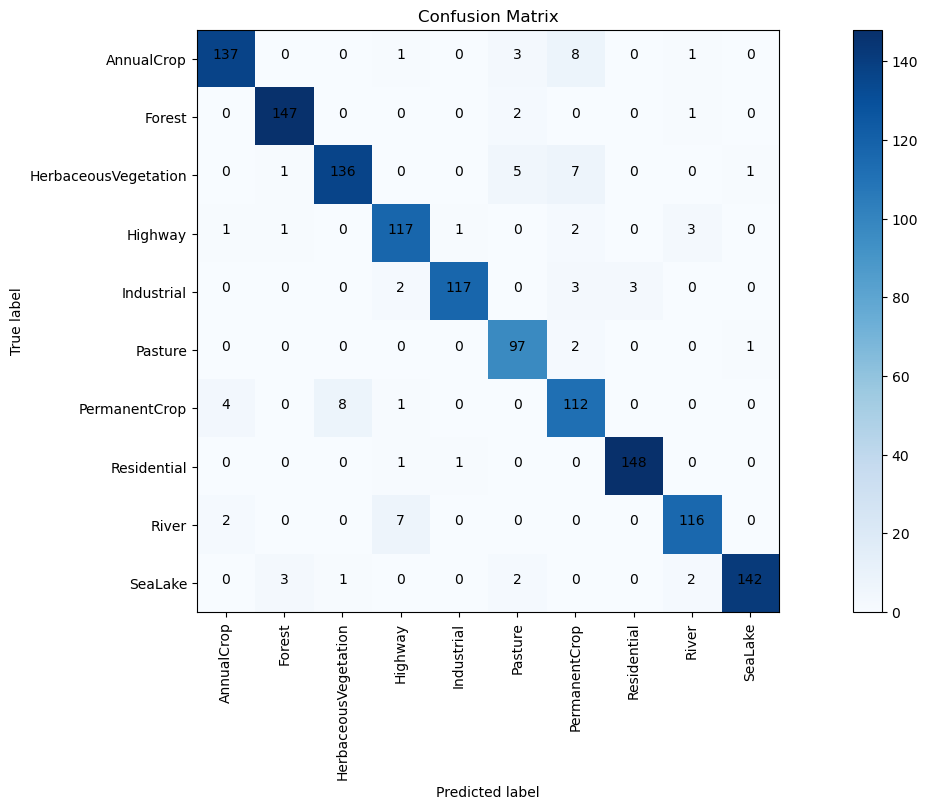

In [28]:
# Print the Confusion Matrix
plot_confusion_matrix(cm, categories, title='Confusion Matrix')

In [29]:
# save trained model, including weights
model.save('land_use_model.keras')

# Viewing the Model Loss and Accuracy

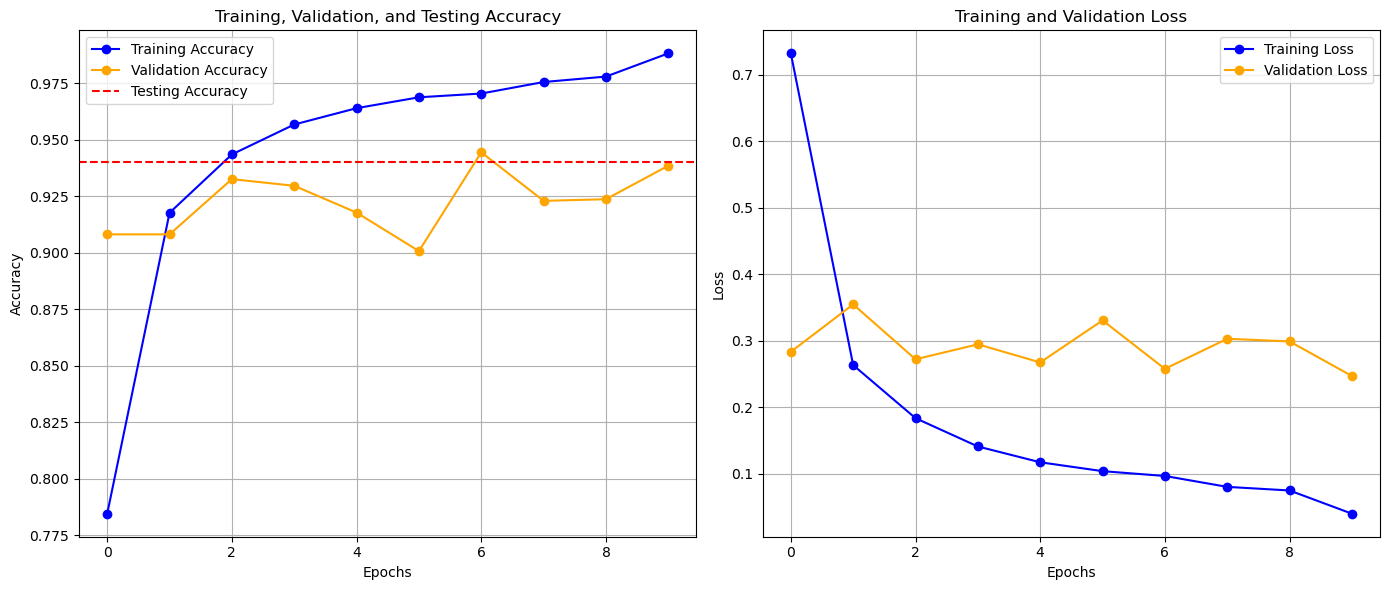

In [30]:
# Extract training and validation accuracy from the history object
acc = history.history['accuracy']  # List of training accuracies for each epoch
val_acc = history.history['val_accuracy']  # List of validation accuracies for each epoch

# Extract training and validation loss from the history object
loss = history.history['loss']  # List of training losses for each epoch
val_loss = history.history['val_loss']  # List of validation losses for each epoch

# Create a range object for the number of epochs
epochs = range(len(acc))  # The range object from 0 to the number of epochs

# Create a new figure with subplots for accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot training and validation accuracy over epochs
ax1.plot(epochs, acc, 'o-', color='blue', label='Training Accuracy')  # Plot training accuracy with blue line and markers
ax1.plot(epochs, val_acc, 'o-', color='orange', label='Validation Accuracy')  # Plot validation accuracy with orange line and markers
ax1.axhline(y=test_accuracy, color='red', linestyle='--', label='Testing Accuracy')  # Add a horizontal line for testing accuracy
ax1.set_title('Training, Validation, and Testing Accuracy')  # Title of the accuracy plot
ax1.set_xlabel('Epochs')  # X-axis label
ax1.set_ylabel('Accuracy')  # Y-axis label
ax1.legend()  # Display the legend to differentiate between training, validation, and testing accuracy
ax1.grid(True)  # Add grid lines for better readability

# Plot training and validation loss over epochs
ax2.plot(epochs, loss, 'o-', color='blue', label='Training Loss')  # Plot training loss with blue line and markers
ax2.plot(epochs, val_loss, 'o-', color='orange', label='Validation Loss')  # Plot validation loss with orange line and markers
ax2.set_title('Training and Validation Loss')  # Title of the loss plot
ax2.set_xlabel('Epochs')  # X-axis label
ax2.set_ylabel('Loss')  # Y-axis label
ax2.legend()  # Display the legend to differentiate between training and validation loss
ax2.grid(True)  # Add grid lines for better readability

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()  # Show the training, validation, and testing accuracy and loss plots

### Generating and Displaying the Classification Report

In [31]:
# Generate a classification report
report = classification_report(test_labels, predictions.argmax(axis=1), target_names=categories)
print(report)

                      precision    recall  f1-score   support

          AnnualCrop       0.95      0.91      0.93       150
              Forest       0.97      0.98      0.97       150
HerbaceousVegetation       0.94      0.91      0.92       150
             Highway       0.91      0.94      0.92       125
          Industrial       0.98      0.94      0.96       125
             Pasture       0.89      0.97      0.93       100
       PermanentCrop       0.84      0.90      0.86       125
         Residential       0.98      0.99      0.98       150
               River       0.94      0.93      0.94       125
             SeaLake       0.99      0.95      0.97       150

            accuracy                           0.94      1350
           macro avg       0.94      0.94      0.94      1350
        weighted avg       0.94      0.94      0.94      1350



### Computing and Plotting Multi-class ROC Curve

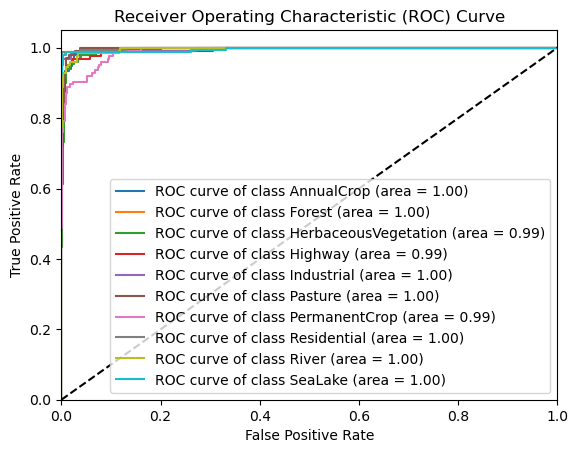

In [32]:
# Binarize the test labels for multi-class ROC curve
y_test_binarized = label_binarize(test_labels, classes=np.arange(len(categories)))
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {categories[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Plotting Learning Rate Schedule

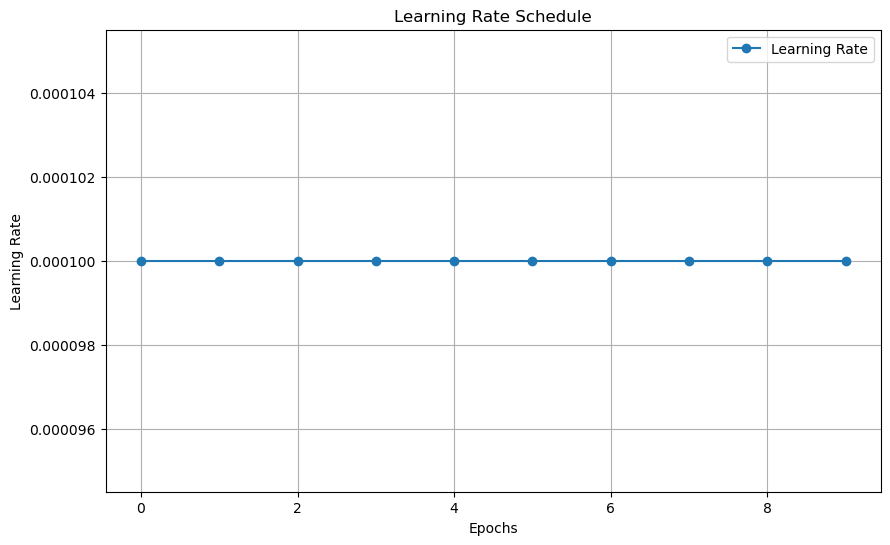

In [33]:
lr_schedule = history.history['lr'] if 'lr' in history.history else [0.0001] * len(epochs)

plt.figure(figsize=(10, 6))
plt.plot(epochs, lr_schedule, 'o-', label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)
plt.show()

### Computing Predictions and Visualising Misclassified Samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


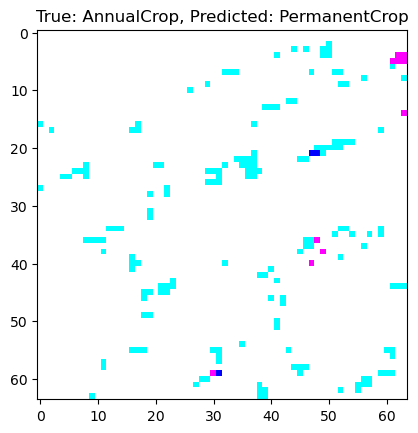

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


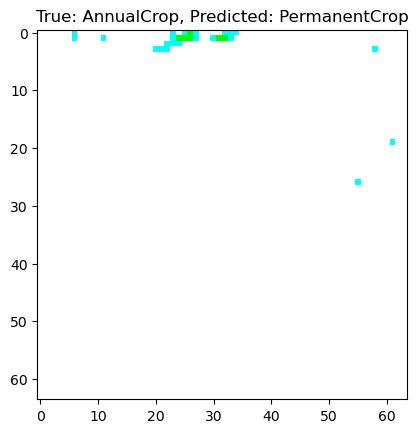

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


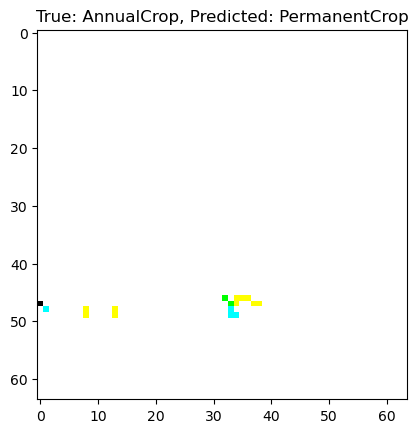

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


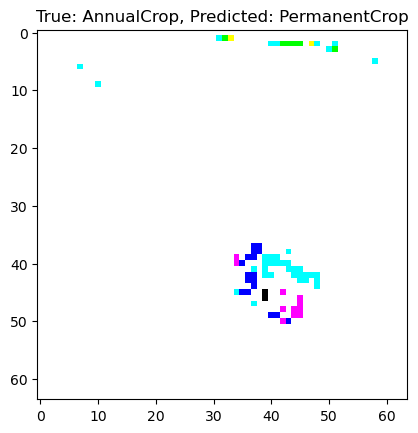

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


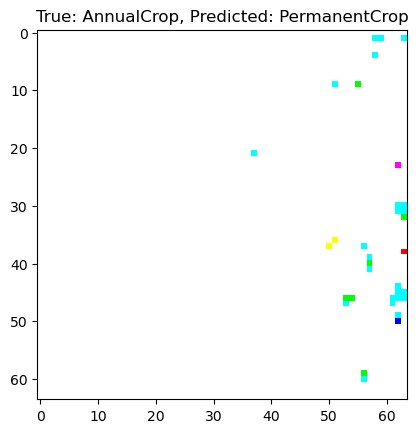

In [34]:
# Step 1: Compute Predictions
predictions = model.predict(test_batches, verbose=0)
predicted_labels = np.argmax(predictions, axis=1)

# Step 2: Extract True Labels and Images
true_labels = []
images = []
test_batches.reset()  # Reset the generator to start from the beginning

for _ in range(len(test_batches)):  # Iterate through the generator
    x_batch, y_batch = next(test_batches)
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoding to class indices
    images.extend(x_batch)

true_labels = np.array(true_labels)
images = np.array(images)

# Ensure the lengths match
assert len(true_labels) == len(predicted_labels), "Mismatch in number of true labels and predictions"

# Step 3: Identify Misclassified Samples
misclassified_indices = np.where(true_labels != predicted_labels)[0]

# Step 4: Visualize Misclassified Samples
for i in range(5):  # Display 5 misclassified samples
    index = misclassified_indices[i]
    plt.imshow(images[index])  # Assuming images contains the raw image data
    plt.title(f"True: {categories[true_labels[index]]}, Predicted: {categories[predicted_labels[index]]}")
    plt.show()

## Images at Intermediate Layers
### Predicting and Displaying Class for Input Image

In [35]:
def load_and_preprocess_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(64, 64))  # Ensure the image size matches the model's input
    img_tensor = image.img_to_array(img)  # Convert image to a numpy array
    img_tensor = np.expand_dims(img_tensor, axis=0)  # Add a batch dimension
    img_tensor /= 255.  # Normalize the image to [0, 1]

    # Visualize the image
    plt.imshow(img_tensor[0])  # Display the image
    plt.show()

    # Ensure the shape matches the model's input requirements
    print("Image tensor shape:", img_tensor.shape)

    return img_tensor, img  # Return the tensor for predictions and the image for visualization

Select a case:
1. Image from test_path
2. Image from dataset_path


Enter case number (1 or 2):  2
Enter the image name (e.g., /MelliehaCut.jpeg):  /GhadiraBay.jpg


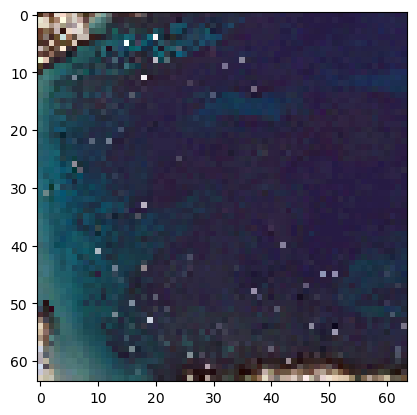

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted class index is: 9
Predicted class label is: SeaLake


In [37]:
flag = True
while flag:
    print("Select a case:")
    print("1. Image from test_path")
    print("2. Image from dataset_path")
    
    try:
        case = int(input("Enter case number (1 or 2): "))
    except ValueError:
        print("Invalid input. Please enter a number (1 or 2).")
        continue
    
    if case == 1:
        image_relative_path = input("Enter the relative path to the image (e.g., /Residential/Residential_26.jpeg): ")
        img_path = test_path + image_relative_path
        img_tensor, img = load_and_preprocess_image(img_path)
        flag = False  # Exit the loop after successful processing

    elif case == 2:
        image_relative_path = input("Enter the image name (e.g., /MelliehaCut.jpeg): ")
        img_path = dataset_path + '/converted-jpg-images' + image_relative_path
        img_tensor, img = load_and_preprocess_image(img_path)
        flag = False  # Exit the loop after successful processing

    else:
        print("Invalid case number. Please select either 1 or 2.")

# Use model.predict to get probabilities for each class
predictions = model.predict(img_tensor, batch_size=1)  # Correct batch_size to 1 for single image prediction

# Use np.argmax to get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Print the predicted class index
print("Predicted class index is:", predicted_class_index)
print("Predicted class label is:", categories[predicted_class_index])


### Visualising Intermediate Activations

In [38]:
# Ensure the model is built by running it on some input data
_ = model.predict(np.zeros((1, 64, 64, 3)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


In [39]:
# Extract intermediate layer outputs
layer_outputs = [layer.output for layer in model.layers[:10]]  # Extracts the outputs of the top 10 layers

# Print each layer output details
for i, output in enumerate(layer_outputs):
    print(f"Layer {i+1} Output:")
    print(f"  Shape: {output.shape}")
    print(f"  Data Type: {output.dtype}")
    print(f"  Sparse: {output.sparse}")
    print(f"  Name: {output.name}")
    print()  # Print an empty line for separation

Layer 1 Output:
  Shape: (None, 64, 64, 64)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_1

Layer 2 Output:
  Shape: (None, 64, 64, 64)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_2

Layer 3 Output:
  Shape: (None, 32, 32, 64)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_3

Layer 4 Output:
  Shape: (None, 32, 32, 128)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_4

Layer 5 Output:
  Shape: (None, 32, 32, 128)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_5

Layer 6 Output:
  Shape: (None, 16, 16, 128)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_6

Layer 7 Output:
  Shape: (None, 16, 16, 256)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_7

Layer 8 Output:
  Shape: (None, 16, 16, 256)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_8

Layer 9 Output:
  Shape: (None, 16, 16, 256)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_9

Layer 10 Output:
  Shape: (None, 8, 8, 256)
  Dat

In [42]:
# Create a new model that will return the outputs of the top 10 layers given the VGG16 input
activation_model = models.Model(inputs=vgg16_model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


### Visualizing Activations of the First 10 Layers of VGG16

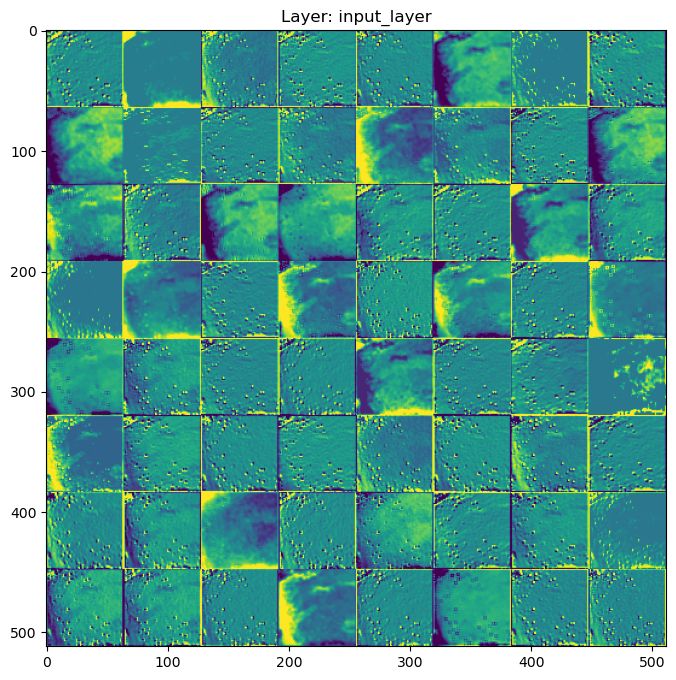

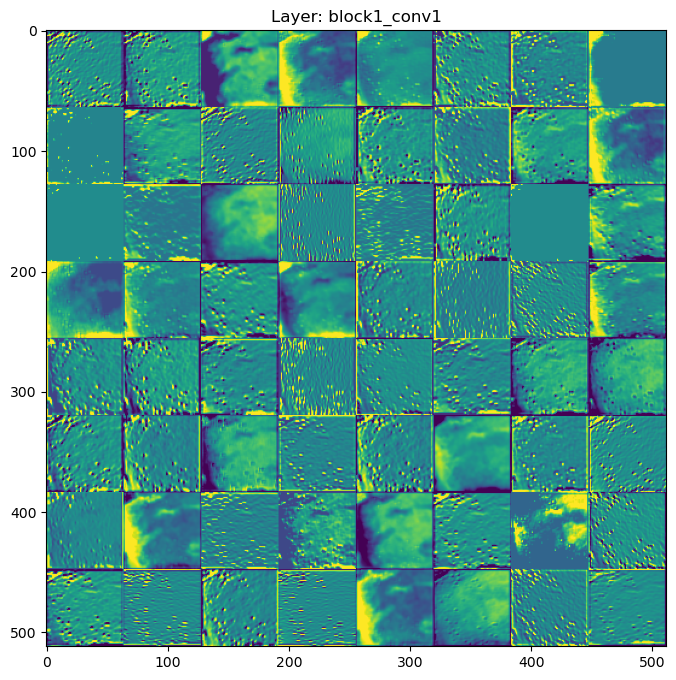

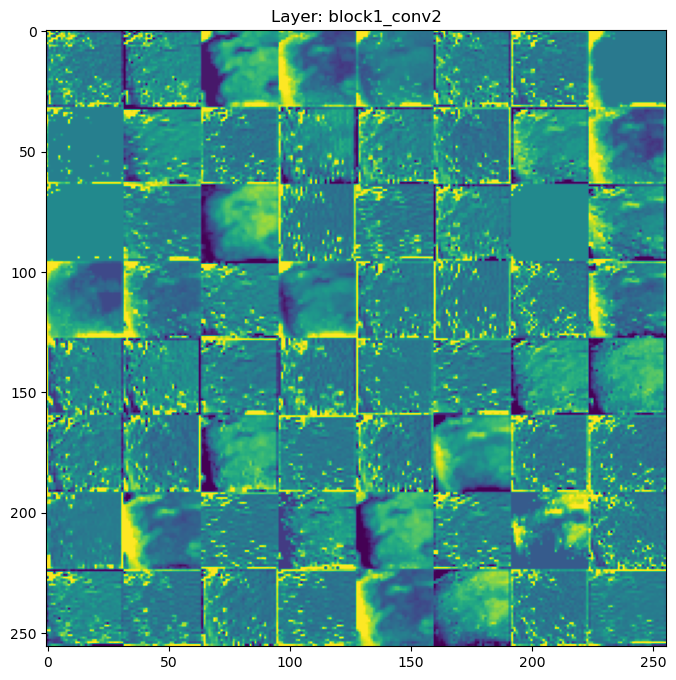

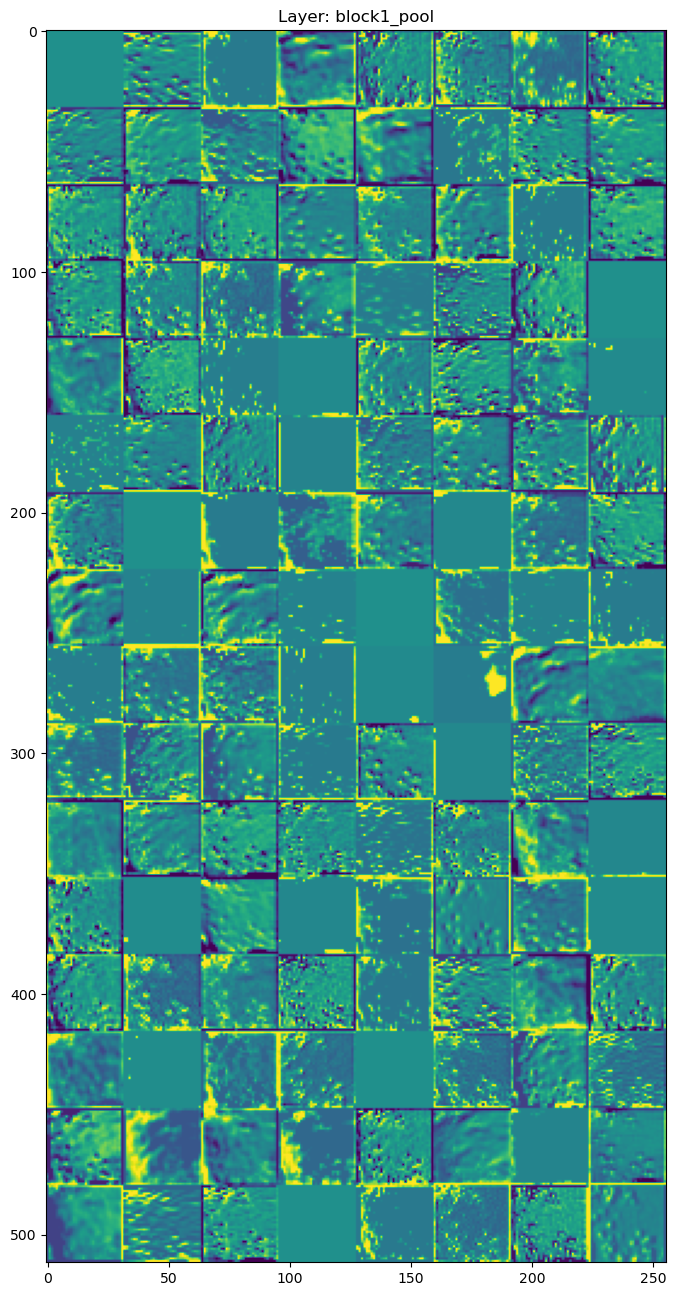

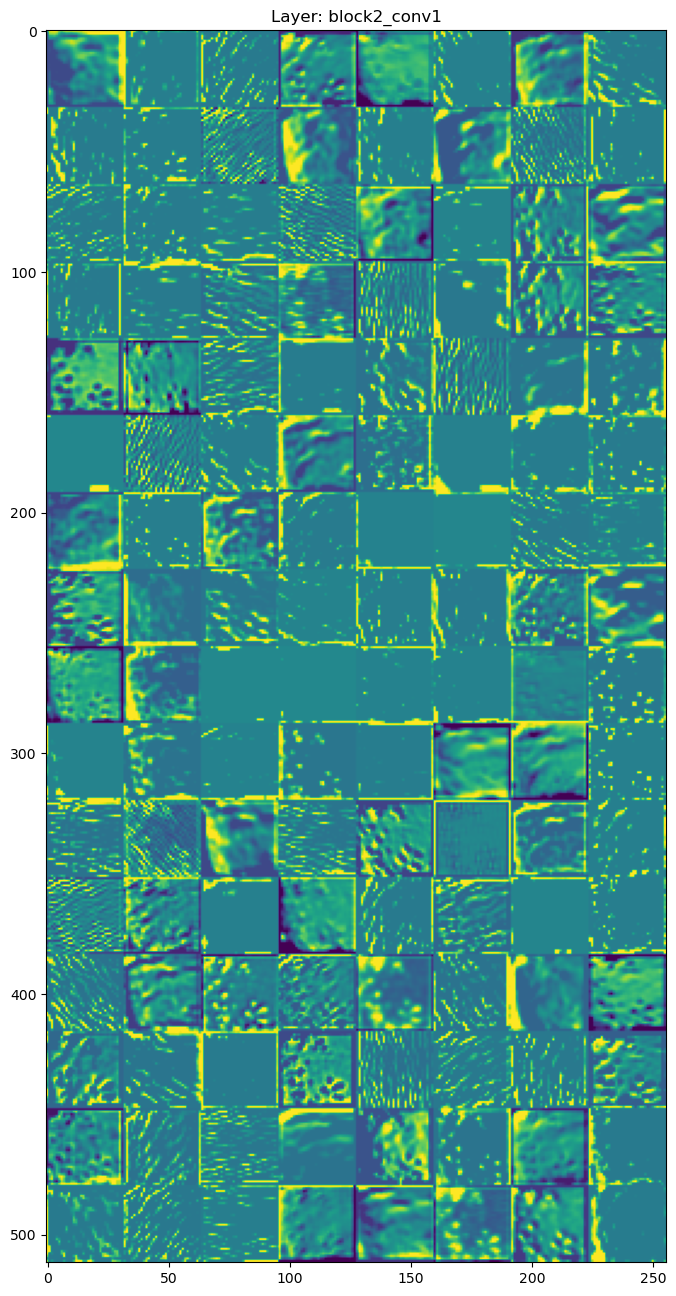

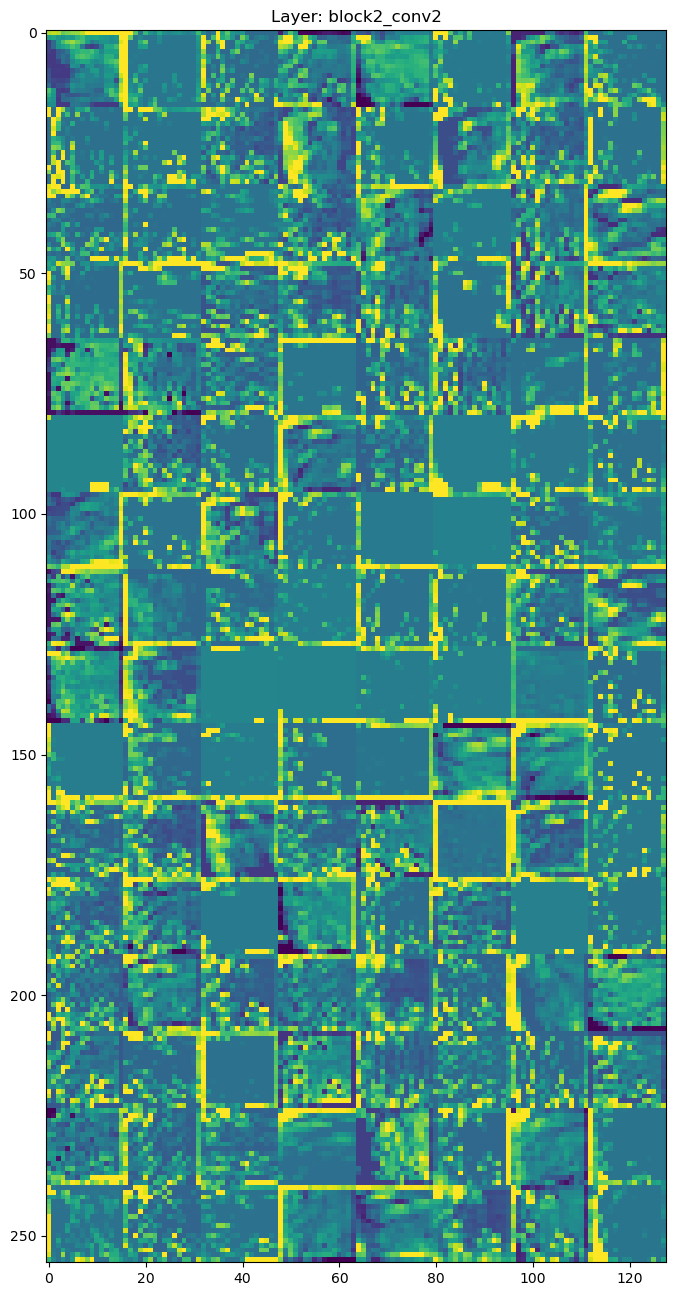

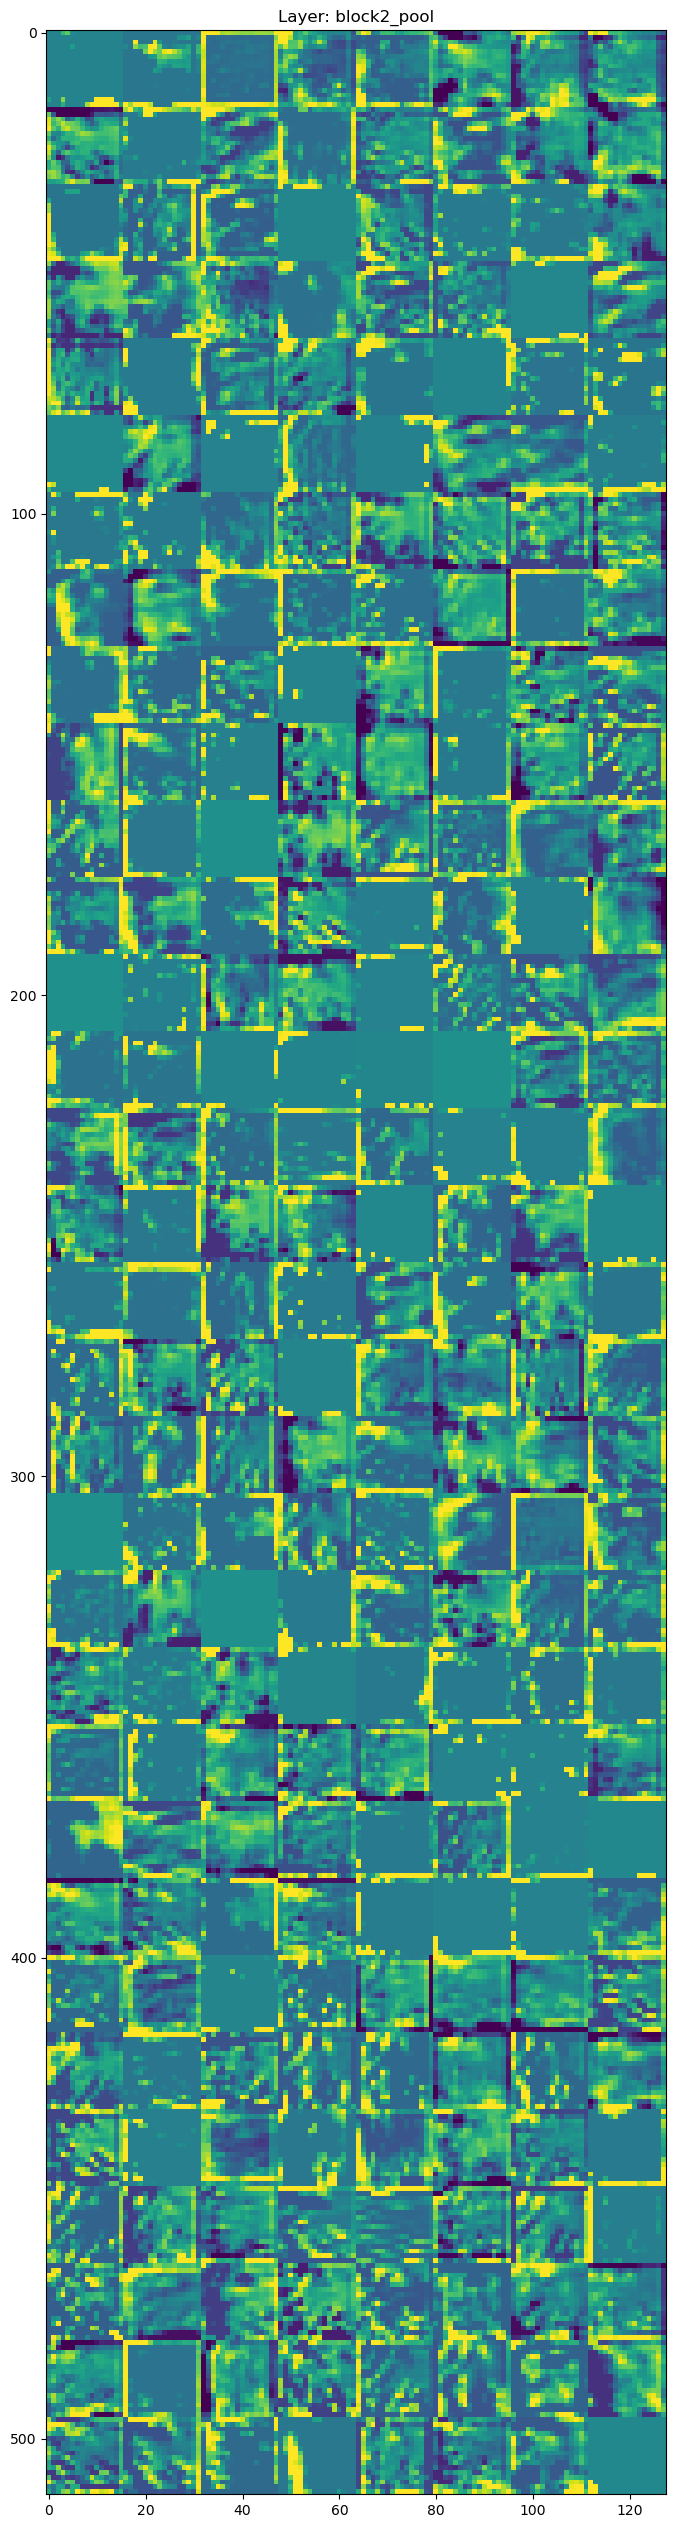

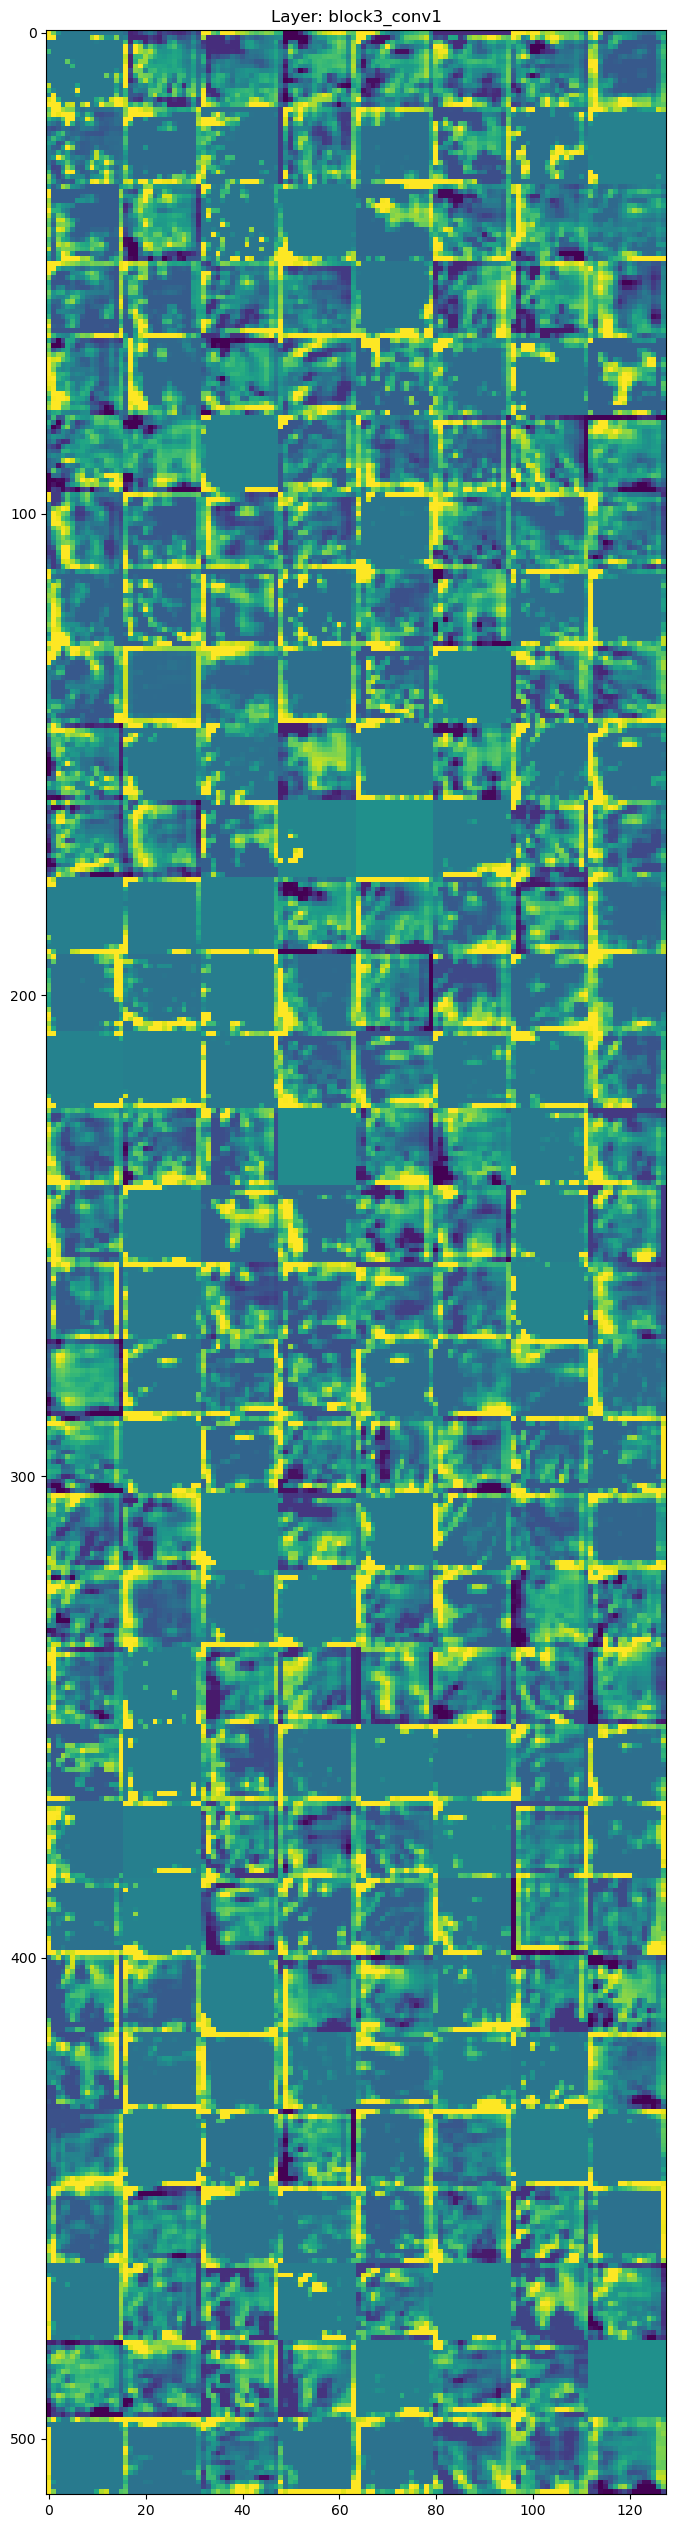

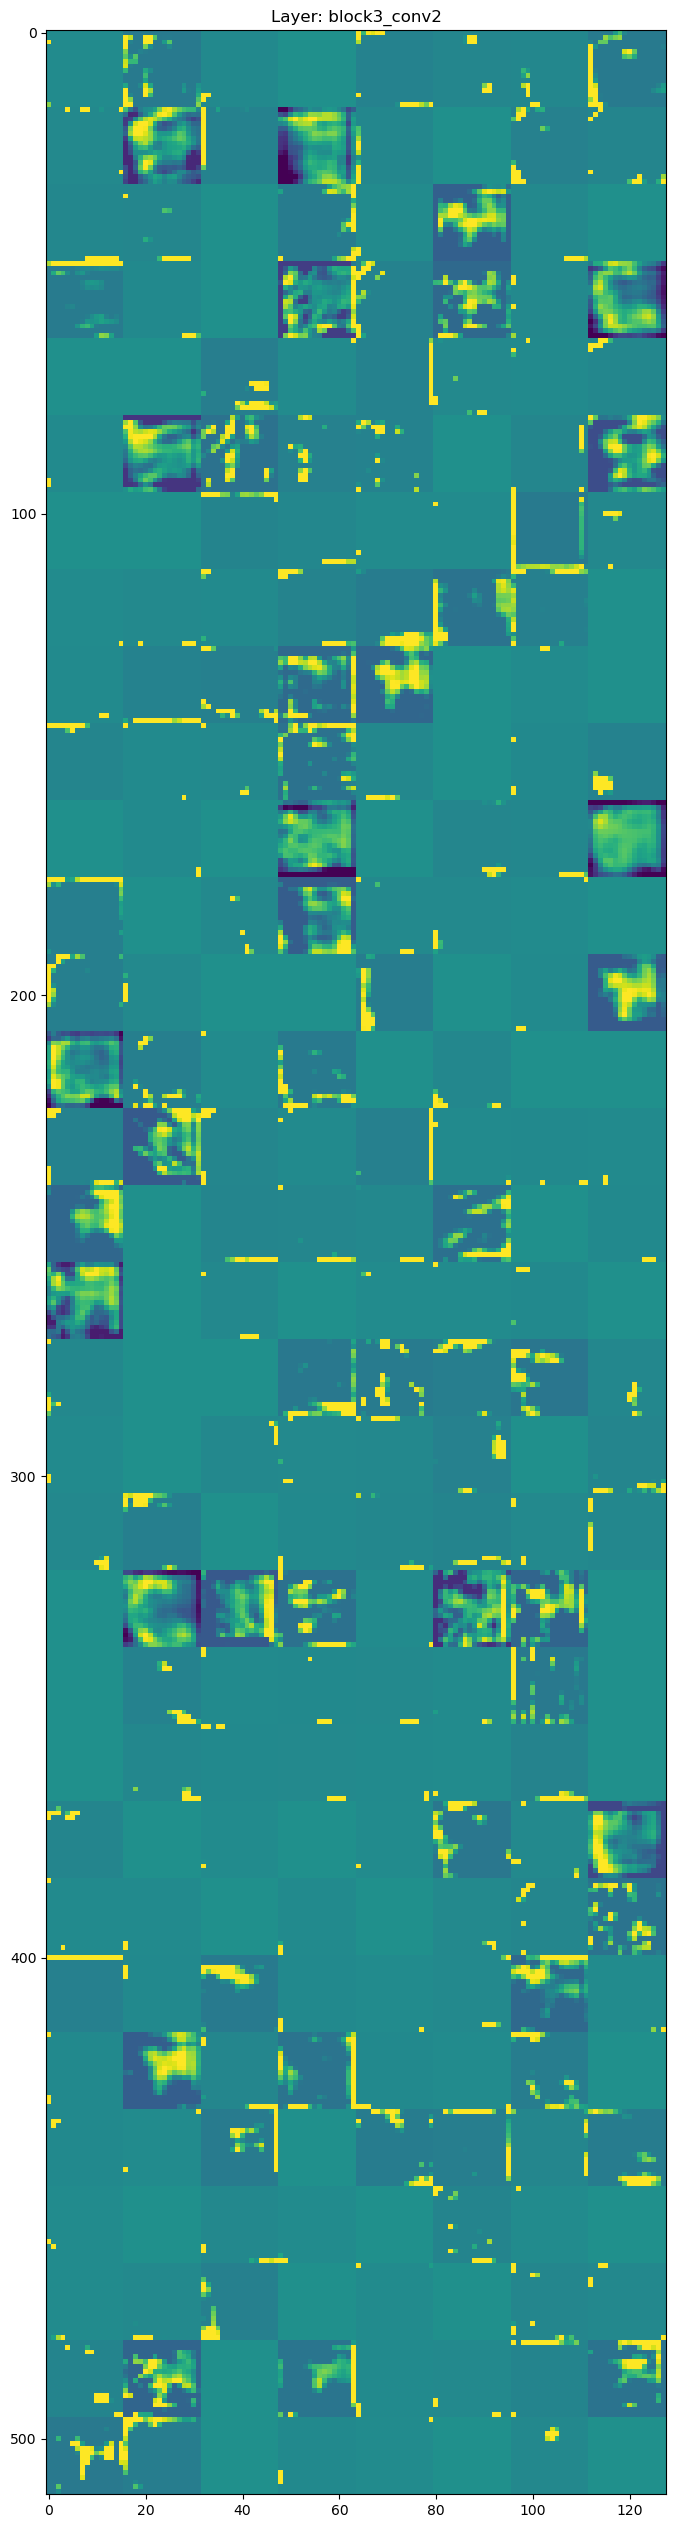

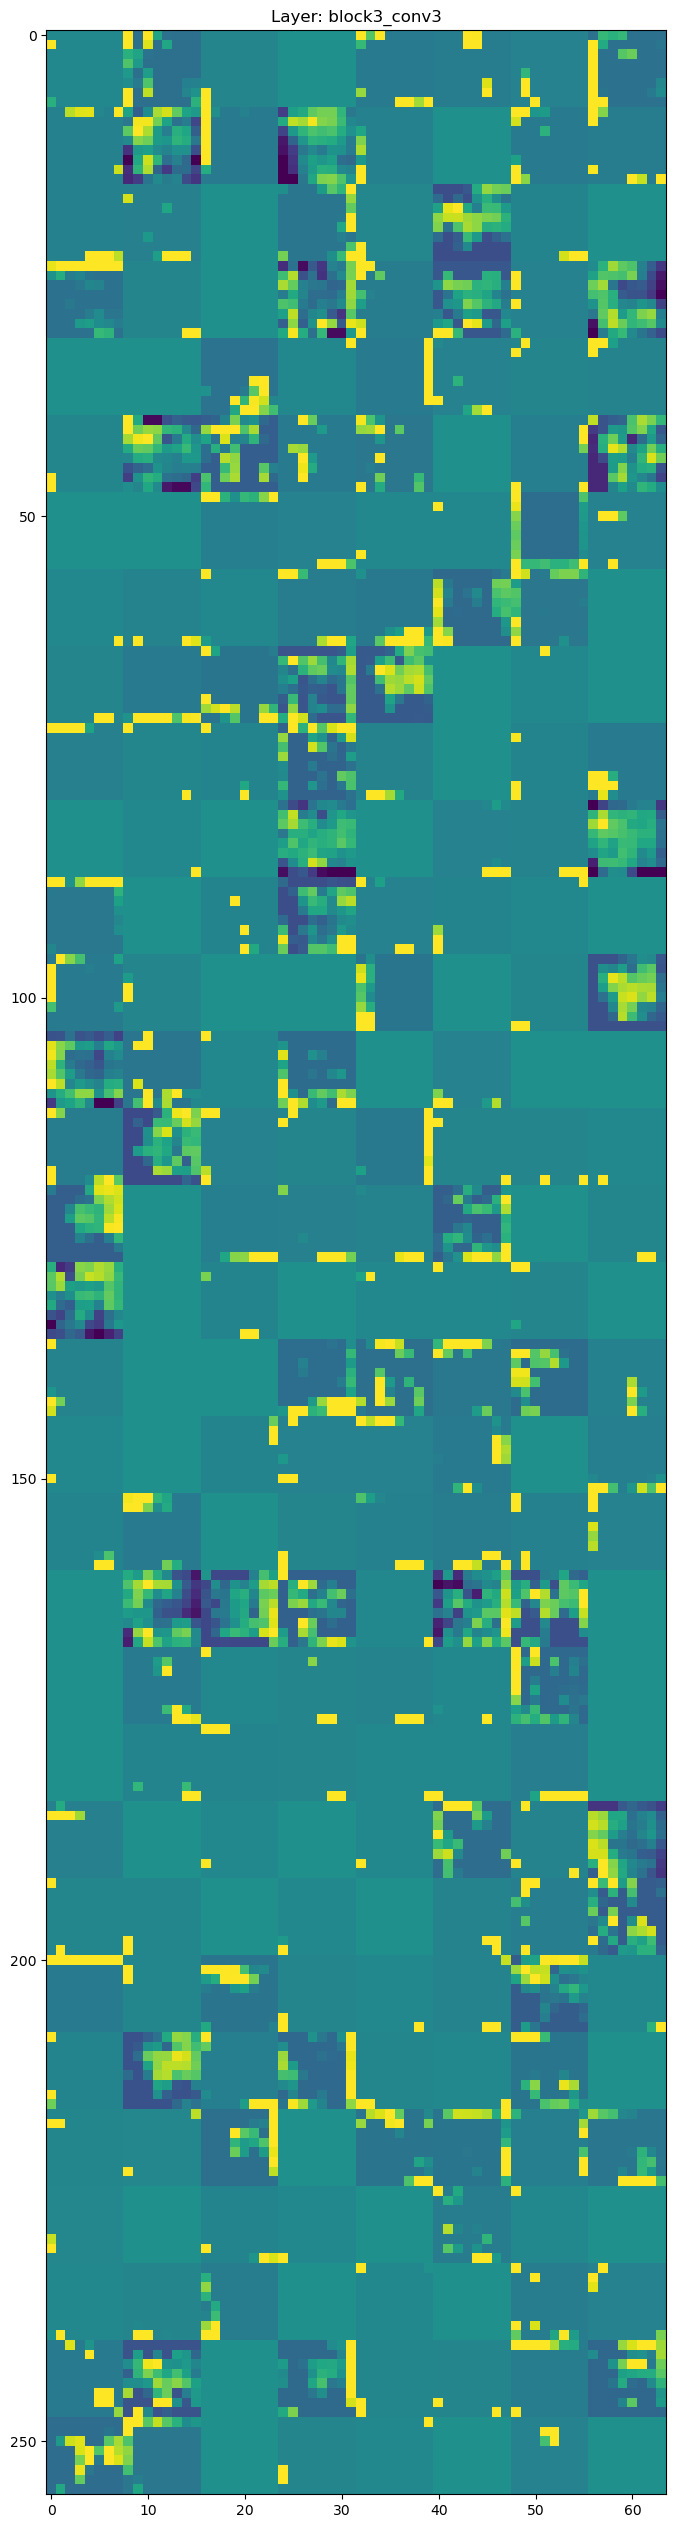

In [43]:
# Define a function to visualize the feature maps of each layer
def plot_activations(activations, layer_names, images_per_row=8):
    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]  # Number of feature maps
        size = layer_activation.shape[1]  # Size of feature maps
        n_cols = min(n_features, images_per_row * (layer_activation.shape[0] // size))  # Display fewer feature maps if there are more than required

        # Create a grid to display the feature maps
        display_grid = np.zeros((size * (n_features // images_per_row), images_per_row * size))

        for col in range(n_features // images_per_row):  # Loop through feature map rows
            for row in range(images_per_row):  # Loop through feature map columns
                if col * images_per_row + row >= n_features:
                    break
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                # Normalize the feature map to have zero mean and unit variance
                channel_image -= channel_image.mean()
                if channel_image.std() > 0:
                    channel_image /= channel_image.std()
                # Enhance contrast for better visualization
                channel_image *= 64
                channel_image += 128
                # Clip the data to be in the range [0, 255] and convert to uint8 for display
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                # Place the image into the correct position in the grid
                display_grid[col * size: (col + 1) * size, row * size: (row + 1) * size] = channel_image

        # Define the scale for the figure size based on the size of the feature maps
        scale = 1. / size
        # Create a new figure for the current layer
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(f'Layer: {layer_name}')  # Set the title of the figure to the layer's name
        plt.grid(False)  # Disable the grid to make the feature maps clearer
        plt.imshow(display_grid, aspect='auto', cmap='viridis')  # Display the feature maps using the 'viridis' colormap

# Extract layer names
layer_names = [layer.name for layer in vgg16_model.layers[:10]]

# Plot activations
plot_activations(activations, layer_names)

### Predicting and Displaying Class for 10 Random Images in EuroSAT Dataset

Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\AnnualCrop\AnnualCrop_2414.jpg


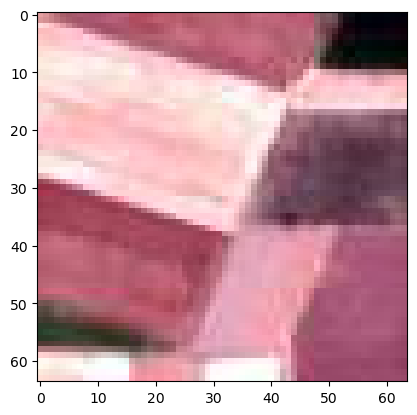

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\Forest\Forest_2361.jpg


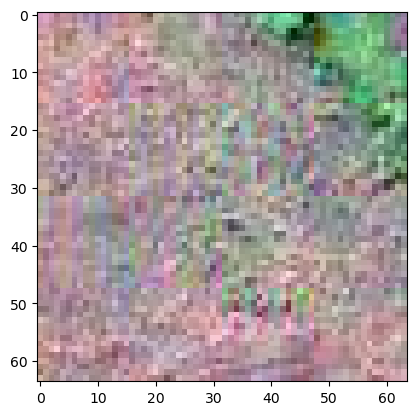

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\HerbaceousVegetation\HerbaceousVegetation_247.jpg


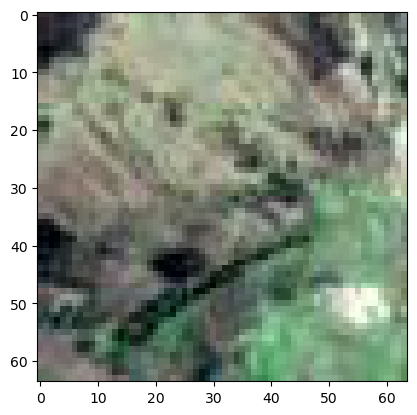

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\Highway\Highway_1702.jpg


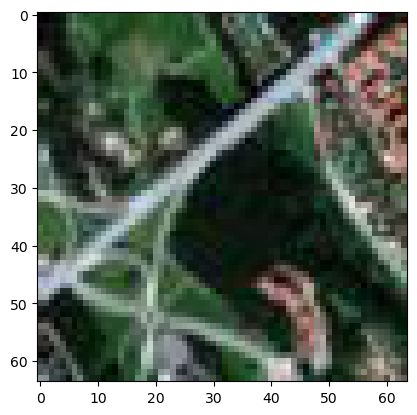

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\Industrial\Industrial_1761.jpg


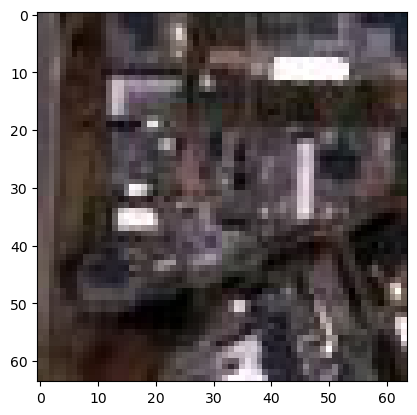

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\Pasture\Pasture_1672.jpg


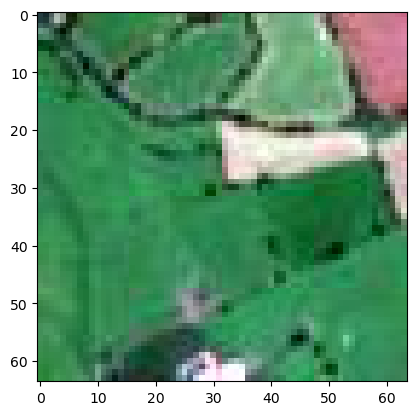

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\PermanentCrop\PermanentCrop_1147.jpg


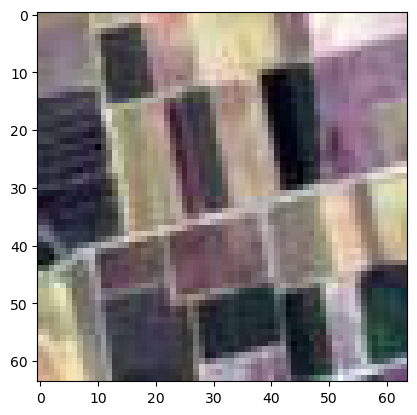

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\Residential\Residential_2235.jpg


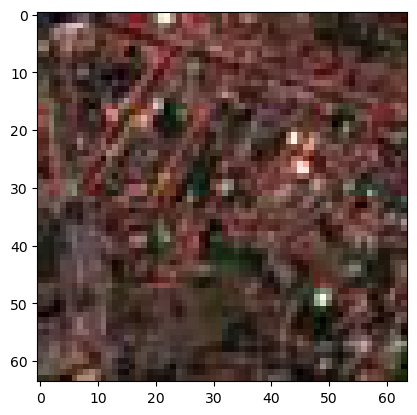

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\River\River_1732.jpg


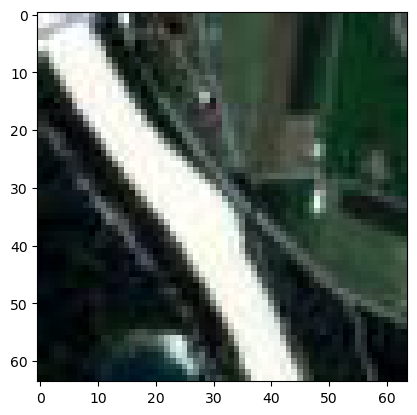

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Selected image path: C:/Users/isaac/datasets/eurosat-dataset\dataset_splits/test\SeaLake\SeaLake_1103.jpg


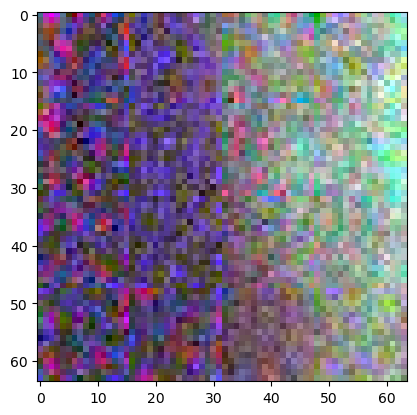

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


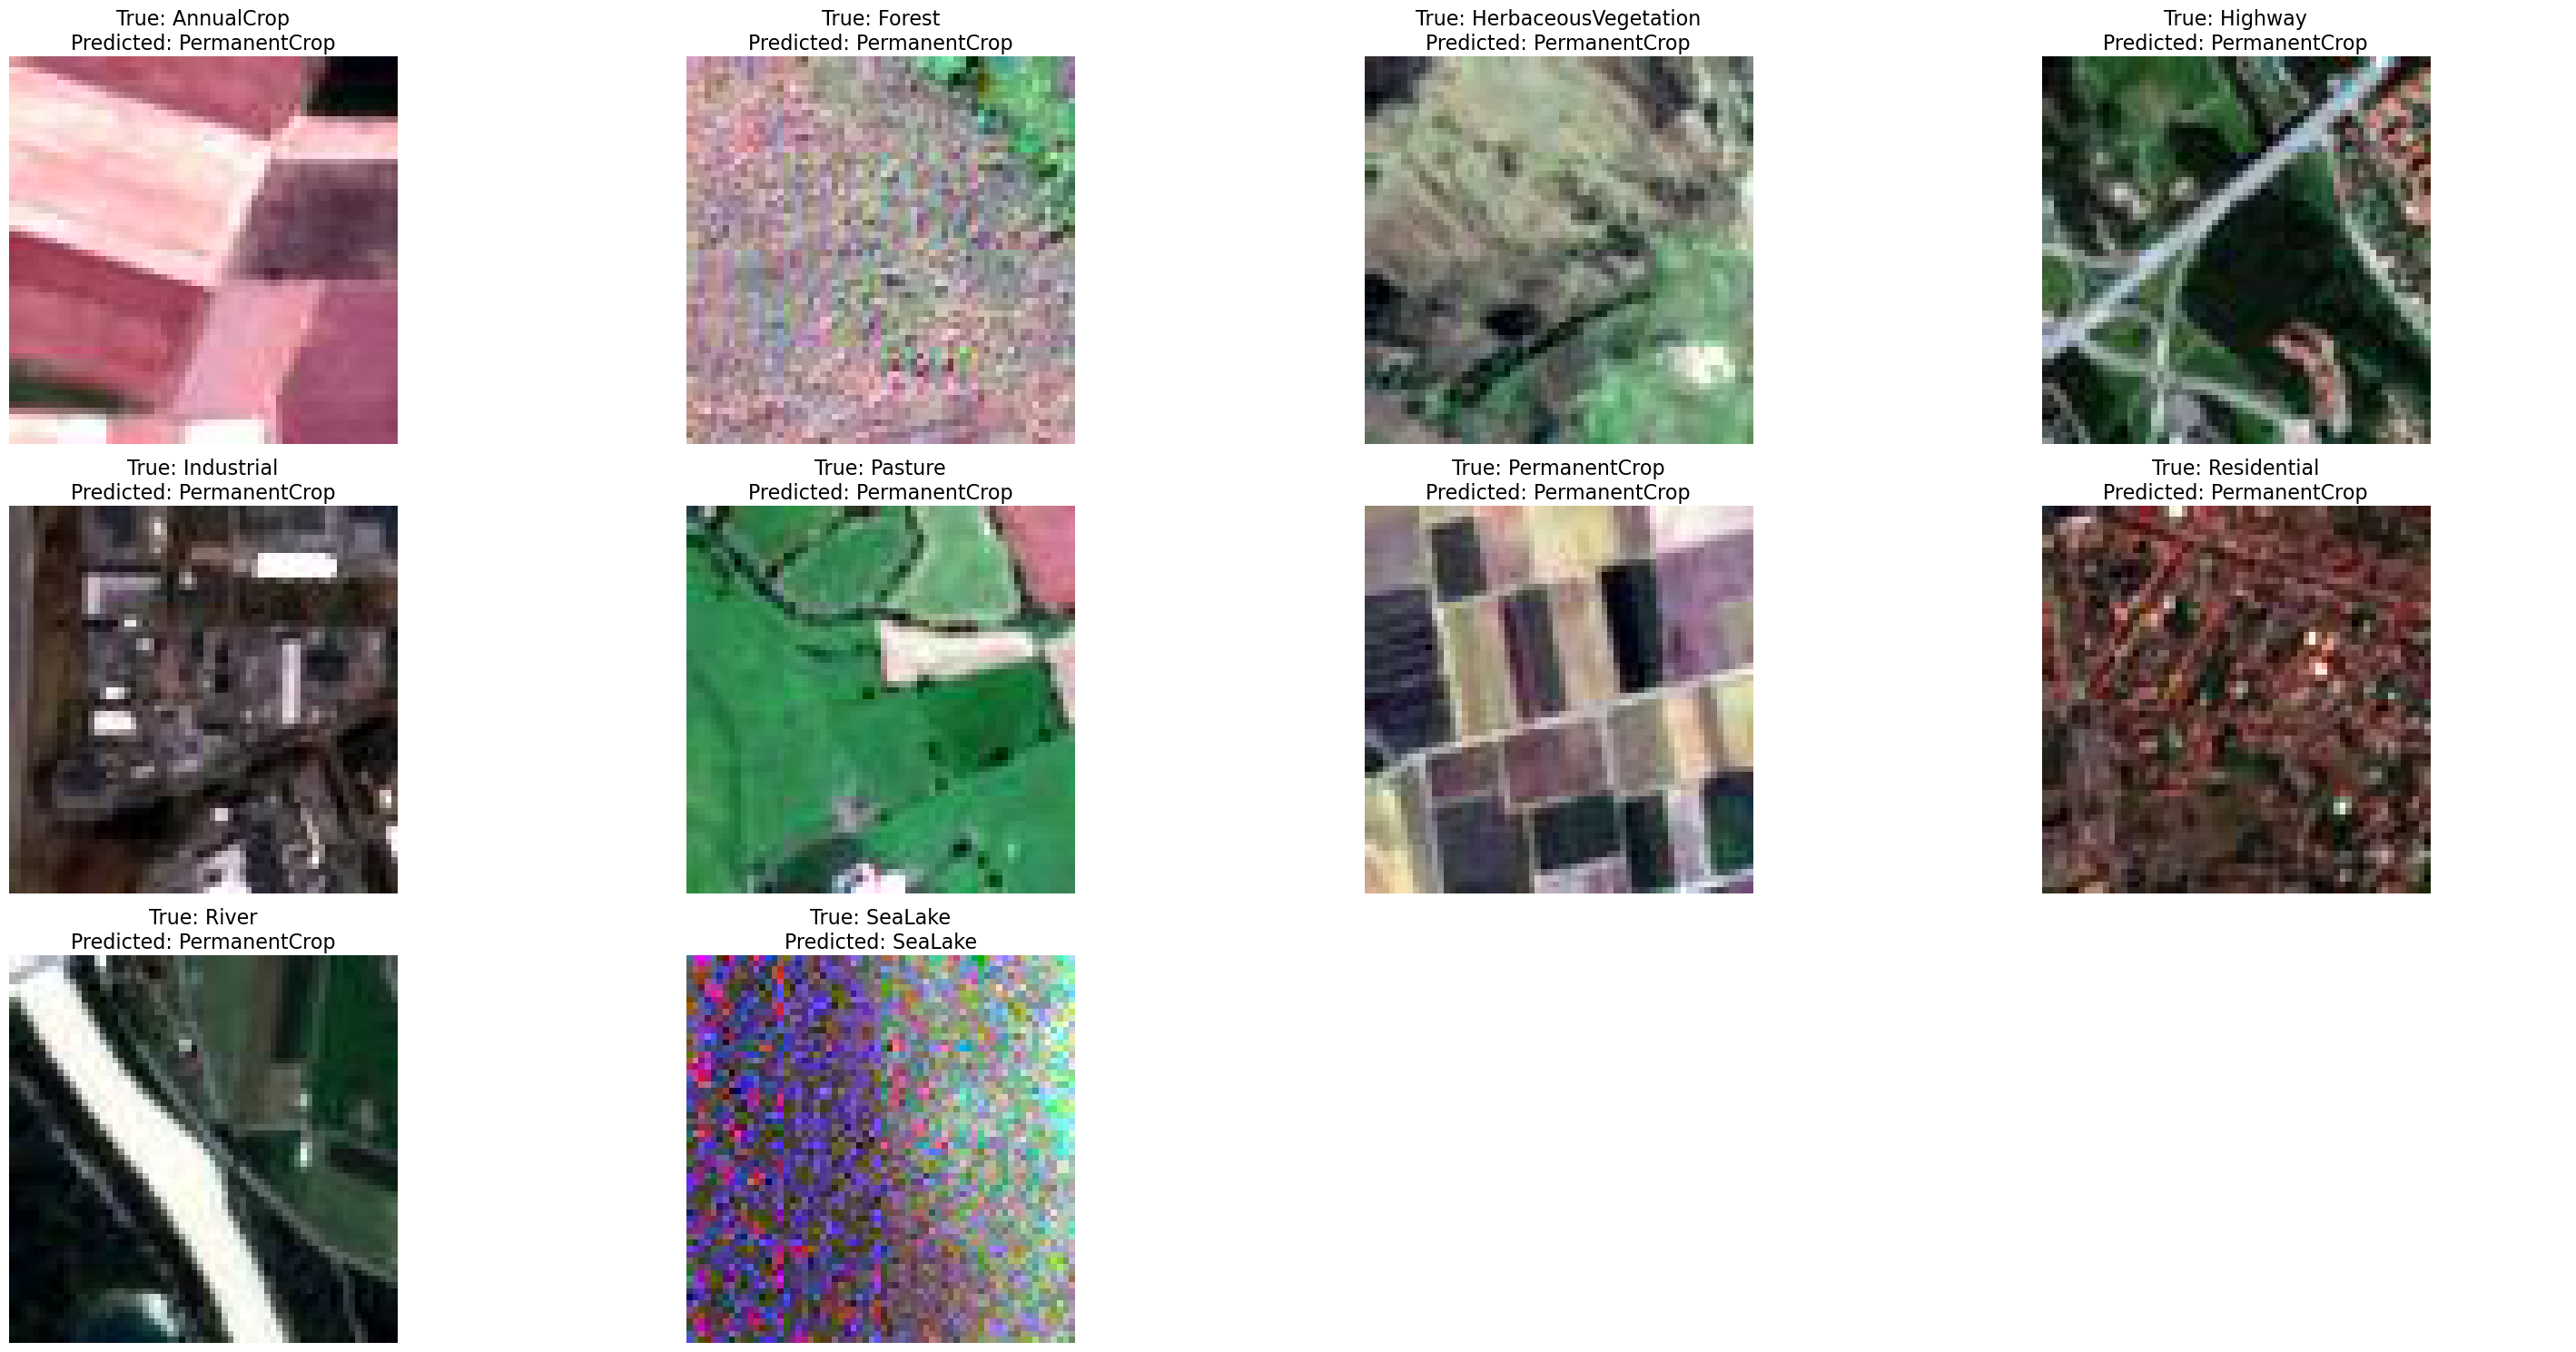

In [44]:
# Randomly select one image from each category and predict its class
selected_images = []
titles = []
for category in categories:
    category_path = os.path.join(test_path, category)
    image_name = random.choice(os.listdir(category_path))
    image_path = os.path.join(category_path, image_name)
    
    print(f"Selected image path: {image_path}")  # Print the path of the selected image
    
    img_tensor, img = load_and_preprocess_image(image_path)
    selected_images.append(image.img_to_array(img))  # Append image in [0, 255] range
    
    # Predict the class
    predictions = model.predict(img_tensor)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    actual_class_index = categories.index(category)
    titles.append(f"True: {category}\nPredicted: {categories[predicted_class_index]}")

# Display all selected images with predictions
plots(selected_images, rows=len(categories)//4 + 1, titles=titles)

### Predicting and Displaying Class for all images in Test Directory

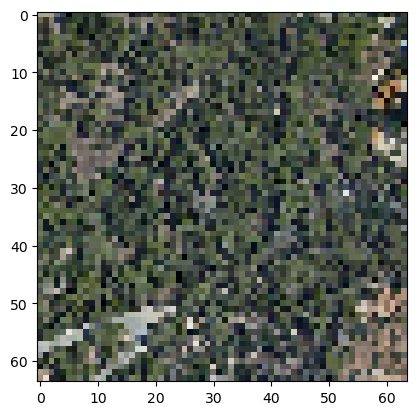

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


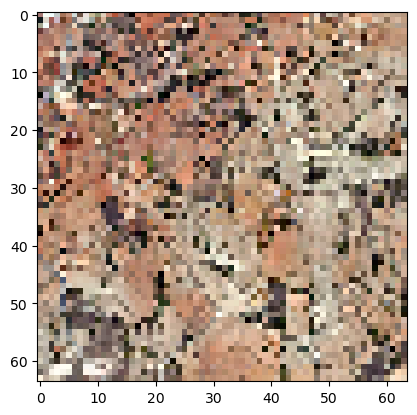

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


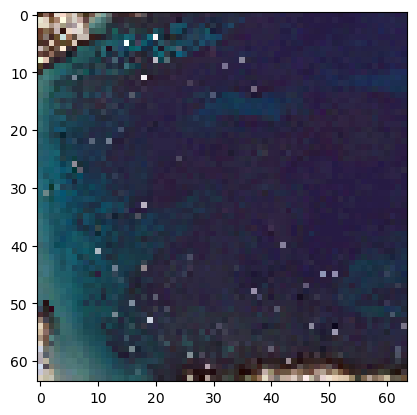

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


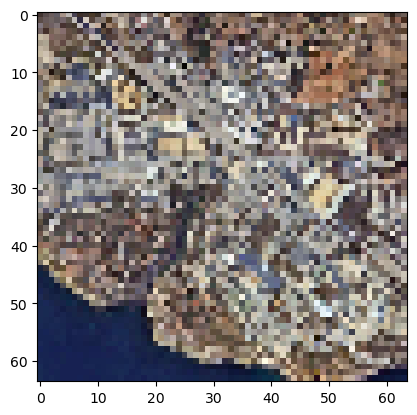

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


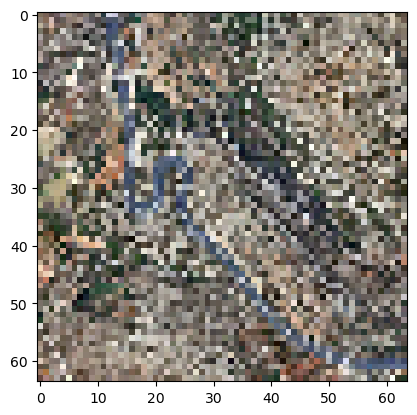

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


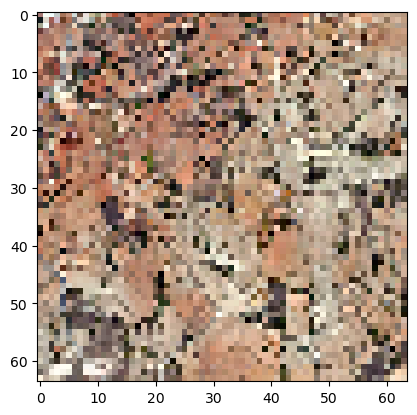

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


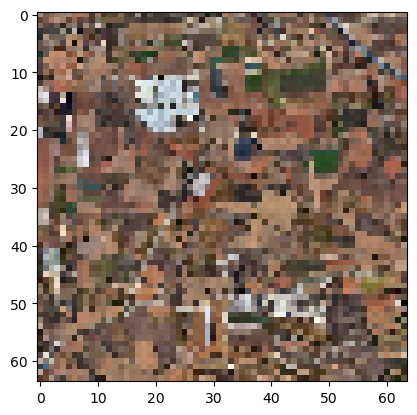

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


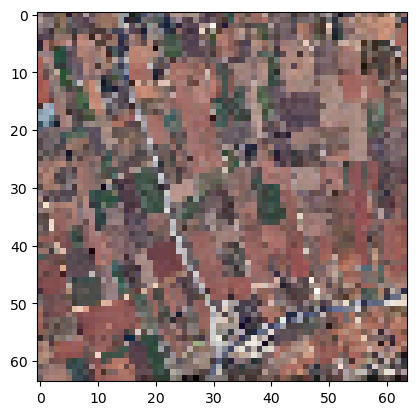

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


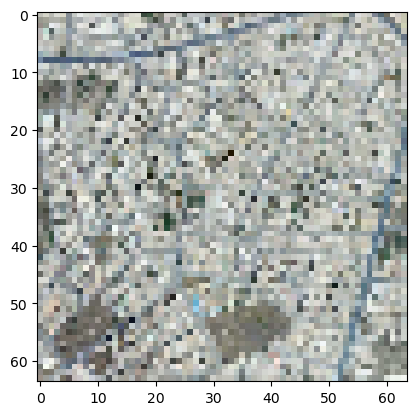

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


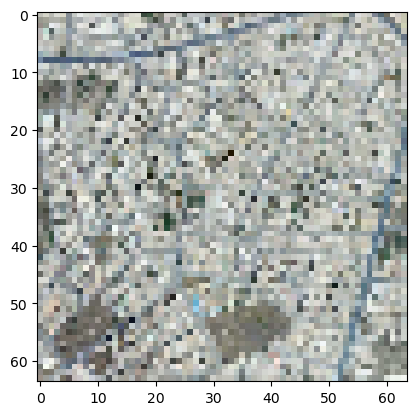

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


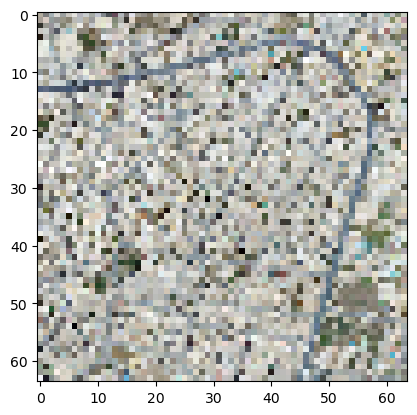

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


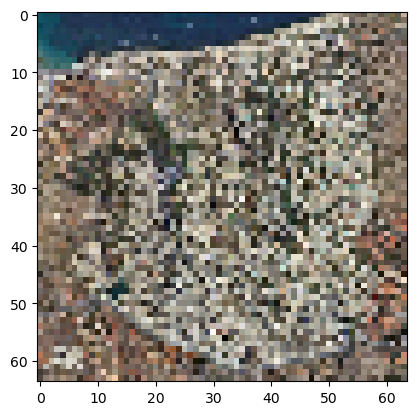

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


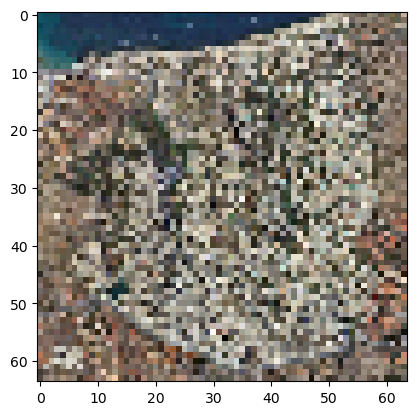

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


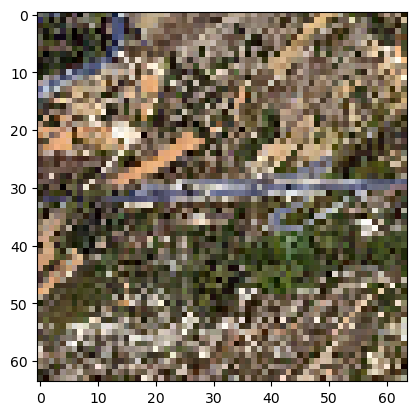

Image tensor shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


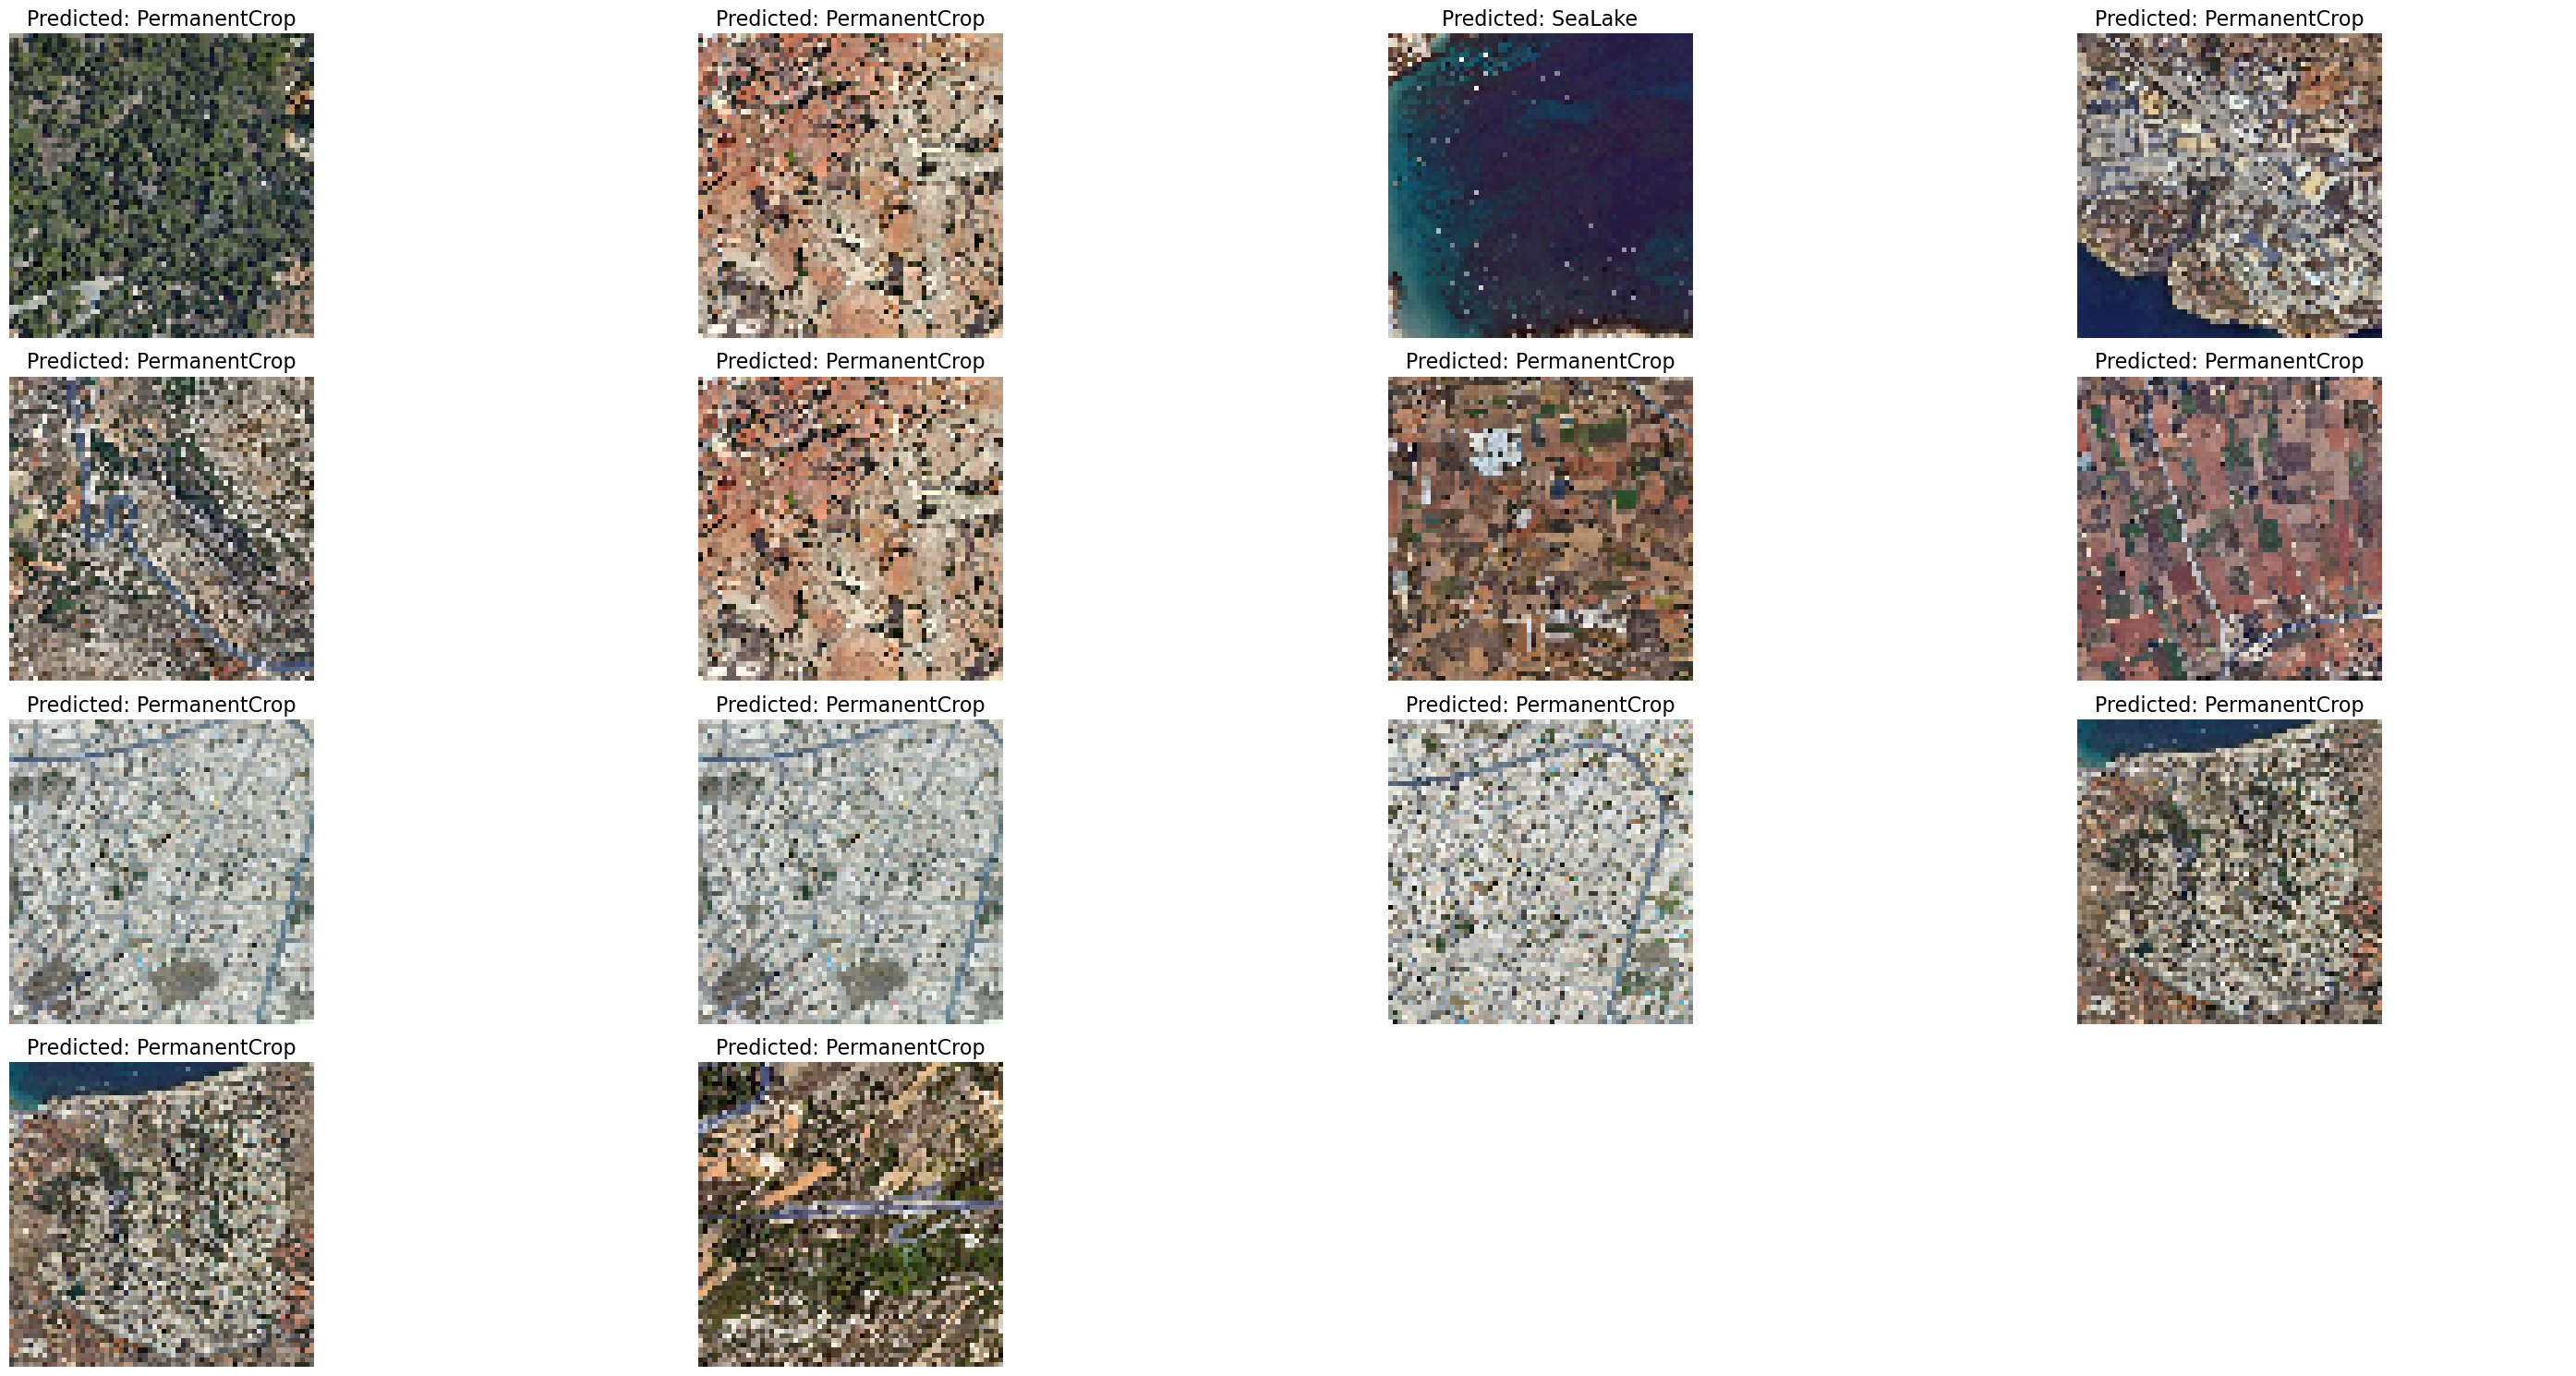

In [45]:
# Define the path to the directory containing the images
image_directory = os.path.join(dataset_path, 'converted-jpg-images')

# Lists to hold the images and their titles
selected_images = []
titles = []

# Loop through all .jpg files in the directory
for filename in os.listdir(image_directory):
    if filename.endswith('.jpg') or filename.endswith('.jpeg'):
        # Full path to the image
        img_path = os.path.join(image_directory, filename)
        
        # Load and preprocess the image
        img_tensor, img = load_and_preprocess_image(img_path)
        
        # Make predictions
        predictions = model.predict(img_tensor)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        
        # Append the image and title
        selected_images.append(image.img_to_array(img))  # Append image in [0, 255] range
        titles.append(f"Predicted: {categories[predicted_class_index]}")

# Display the images and their predictions
plots(selected_images, rows=len(selected_images)//4 + 1, titles=titles)